#Student Placement

In today's competitive job market, students often struggle to determine the best career paths based on their skills and academic performance.

Machine learning offers a potential solution by analyzing academic records, technical skills, and personal attributes to identify key factors influencing career placement.

- Our goal is to develop a data-driven framework that assists students and educational institutions in making informed career decisions.
--------------------------
# Research Question:
Can machine learning accurately predict student career placements based on academic performance, technical skills, and personal attributes?

#Step 0: Data Loading and basic info

👉 Import Libraries📚:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from scipy.stats import zscore
import shap
import joblib
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns

Load Dataset:

In [ ]:
data = pd.read_csv("Student Placement.csv")
data.head()

DSA  DBMS  OS  CN  Mathmetics  Aptitute  Comm  Problem Solving  Creative  \
0   49    22  41  26           7        28    61                1         8   
1   39    46  45  47           3        35    65                4        10   
2   28    32  45  35          10        23    85                3        10   
3   52    38  33  38          19        27    62                1         9   
4   23    31  30  38          10        13    72                4         8   

   Hackathons     Skill 1    Skill 2 Profile  
0           3  Javascript  Photoshop   UI/UX  
1           4    HTML/CSS     GitHub   UI/UX  
2           3   Photoshop      Figma   UI/UX  
3           3   Photoshop      Figma   UI/UX  
4           5    HTML/CSS      Figma   UI/UX

In [ ]:
data.shape

(707, 13)

 Our data set contains 13 Columns, and 707 observations

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   DSA              707 non-null    int64 
 1   DBMS             707 non-null    int64 
 2   OS               707 non-null    int64 
 3   CN               707 non-null    int64 
 4   Mathmetics       707 non-null    int64 
 5   Aptitute         707 non-null    int64 
 6   Comm             707 non-null    int64 
 7   Problem Solving  707 non-null    int64 
 8   Creative         707 non-null    int64 
 9   Hackathons       707 non-null    int64 
 10  Skill 1          707 non-null    object
 11  Skill 2          707 non-null    object
 12  Profile          707 non-null    object
dtypes: int64(10), object(3)
memory usage: 71.9+ KB


types of our Database columns.

In [ ]:
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = data.select_dtypes(include=['object', 'category']).columns

print(f"Number of numerical columns: {len(numerical_cols)}")
print(f"Number of categorical columns: {len(categorical_cols)}")


Number of numerical columns: 10
Number of categorical columns: 3


👉 Our data set contains 10 numerical columns and 3 categorical columns.

👉 Insights from our data:
- 10 numerical columns (DSA, DBMS, OS, CN, Mathmetics, Aptitute, Comm, Problem solving, Creative, Hackathons.)
- 3 categorical columns (Skill 1, Skill 2, Profile)

In [ ]:
data.describe()
print("Min & Max values for numerical columns:")
print(data.describe().loc[["min", "max"]])

Min & Max values for numerical columns:
      DSA   DBMS    OS     CN  Mathmetics  Aptitute  Comm  Problem Solving  \
min   5.0    5.0   5.0    5.0         0.0      13.0  40.0              1.0   
max  99.0  100.0  95.0  100.0        99.0      99.0  90.0             10.0   

     Creative  Hackathons  
min       2.0         0.0  
max      10.0        10.0  


👉 Generates summary statistics for all categorial columns in the dataset, This command filters only the minimum and maximum values from the full statistical summary.

In [ ]:
missing_values = data.isnull().sum()
print("Missing values per column:\n", missing_values[missing_values > 0])


duplicates = data.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

if duplicates > 0:
    print("\nDuplicate rows:")
    display(data[data.duplicated(keep=False)])

Missing values per column:
 Series([], dtype: int64)

Number of duplicate rows: 0


👉 This code checks for missing values and duplicate rows.
- All Columns contain 707 values, there are no missing values at all.

In [ ]:
categorical_columns = ["Skill 1", "Skill 2", "Profile"]
for col in categorical_columns:
    print(f"\n {col} Num of Categories : {data[col].nunique()}")
    print(data[col].value_counts())



 Skill 1 Num of Categories : 23
Skill 1
HTML/CSS               94
Python                 83
C/C++                  57
GitHub                 51
Javascript             42
Linux                  38
Java                   30
Angular                29
Oracle                 27
Photoshop              26
React                  26
Ansible                22
MYSQL                  22
R                      19
Tensorflow             19
Deep Learning          18
Wire Shark             18
Figma                  17
Node.js                16
BASH/SHELL             16
Pytorch                15
Machine Learning       11
Cisco Packet tracer    11
Name: count, dtype: int64

 Skill 2 Num of Categories : 23
Skill 2
HTML/CSS               94
C/C++                  66
Python                 55
Javascript             51
Java                   43
Linux                  41
GitHub                 32
MYSQL                  30
Angular                27
Oracle                 25
Photoshop              25
React   

👉 This code analyzes categorical features by counting unique values and their frequency, helping to detect data imbalances and guide preprocessing steps.
- Career Profile Distribution (Profile):
The distribution is uniform across the 7 different categories, each containing exactly 101 entries.

-----------------------

# Step 1: EDA

In [ ]:
sns.set(style="whitegrid")

In [ ]:
def plot_categorical(data, column):
    fig, ax = plt.subplots(1, 2, figsize=(22, 8))

    # Bar Plot
    sns.countplot(x=column, data=data, ax=ax[0], order=data[column].value_counts().index)
    ax[0].set_title(f'Bar Plot of {column}', fontsize=16)
    ax[0].set_xlabel(column, fontsize=14)
    ax[0].set_ylabel('Count', fontsize=14)
    ax[0].tick_params(axis='x', rotation=45, labelsize=12)

    # Pie Chart
    values = data[column].value_counts()
    explode = [0.1] * len(values)
    wedges, texts, autotexts = ax[1].pie(
        values,
        labels=values.index,
        autopct='%1.0f%%',
        startangle=140,
        colors=sns.color_palette("pastel"),
        textprops={'fontsize': 14, 'weight': 'bold'},
        wedgeprops={'linewidth': 1, 'edgecolor': 'black'},
        pctdistance=0.8,
        labeldistance=1.4,
        explode=explode,
        shadow=True
    )

    for text in texts:
        text.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='black', boxstyle='round,pad=0.3'))

    ax[1].set_title(f'Pie Chart of {column}', fontsize=16)
    ax[1].set_ylabel('')

    plt.tight_layout()
    plt.show()

- Categorical variables

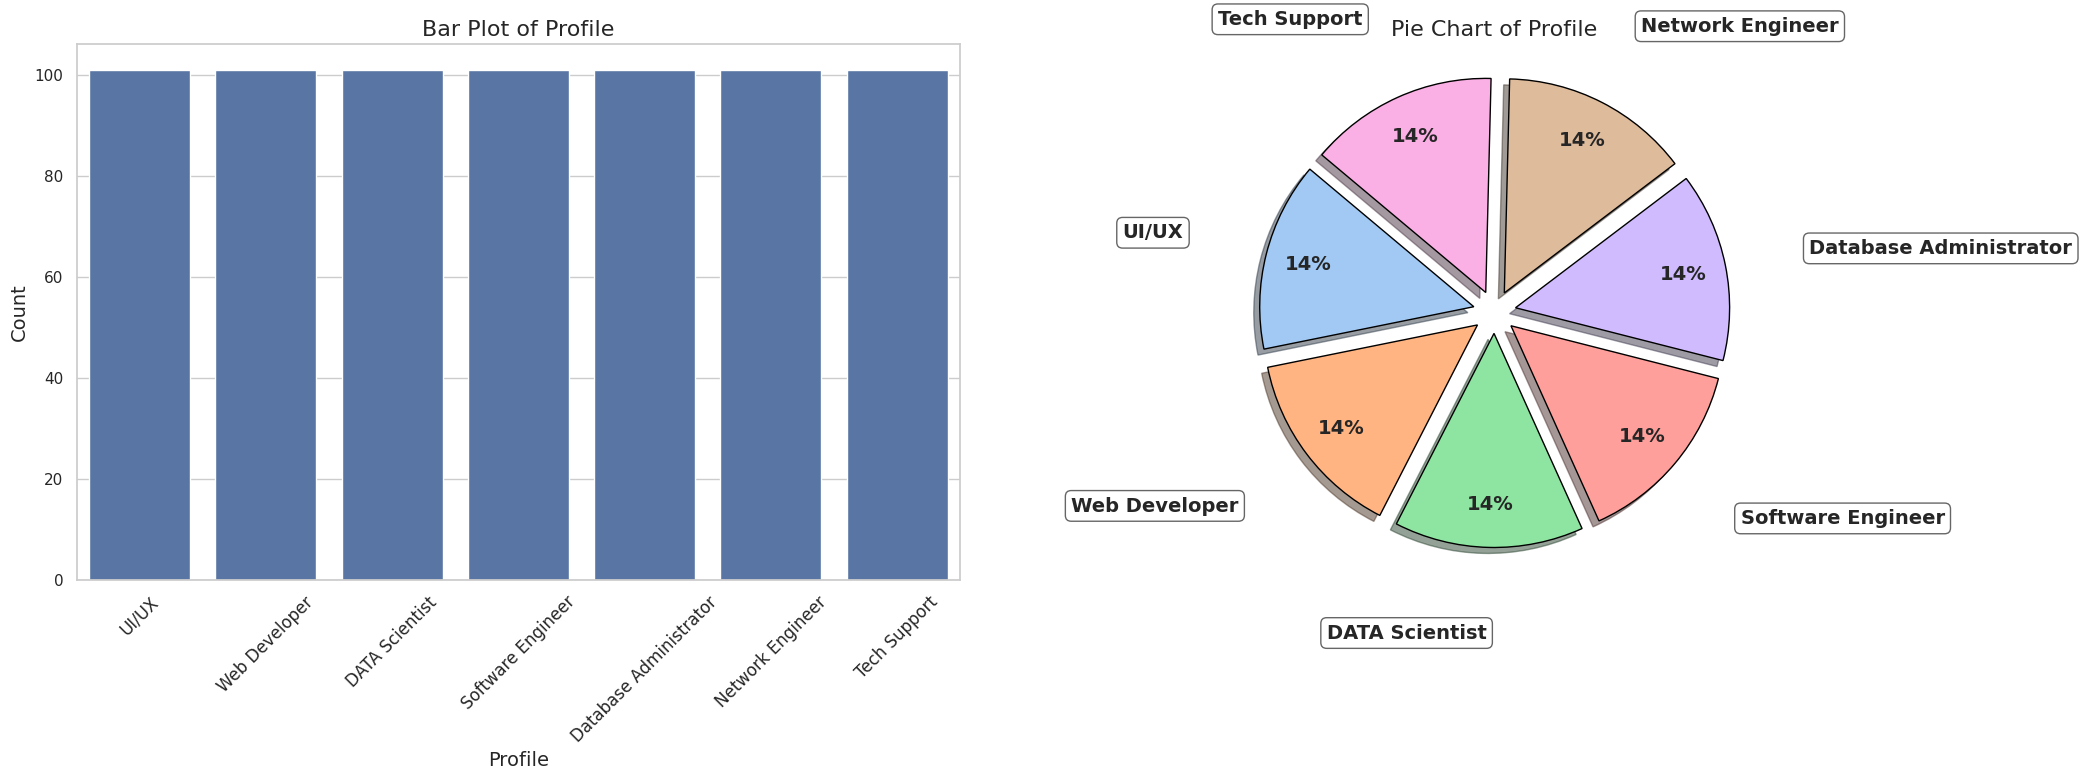

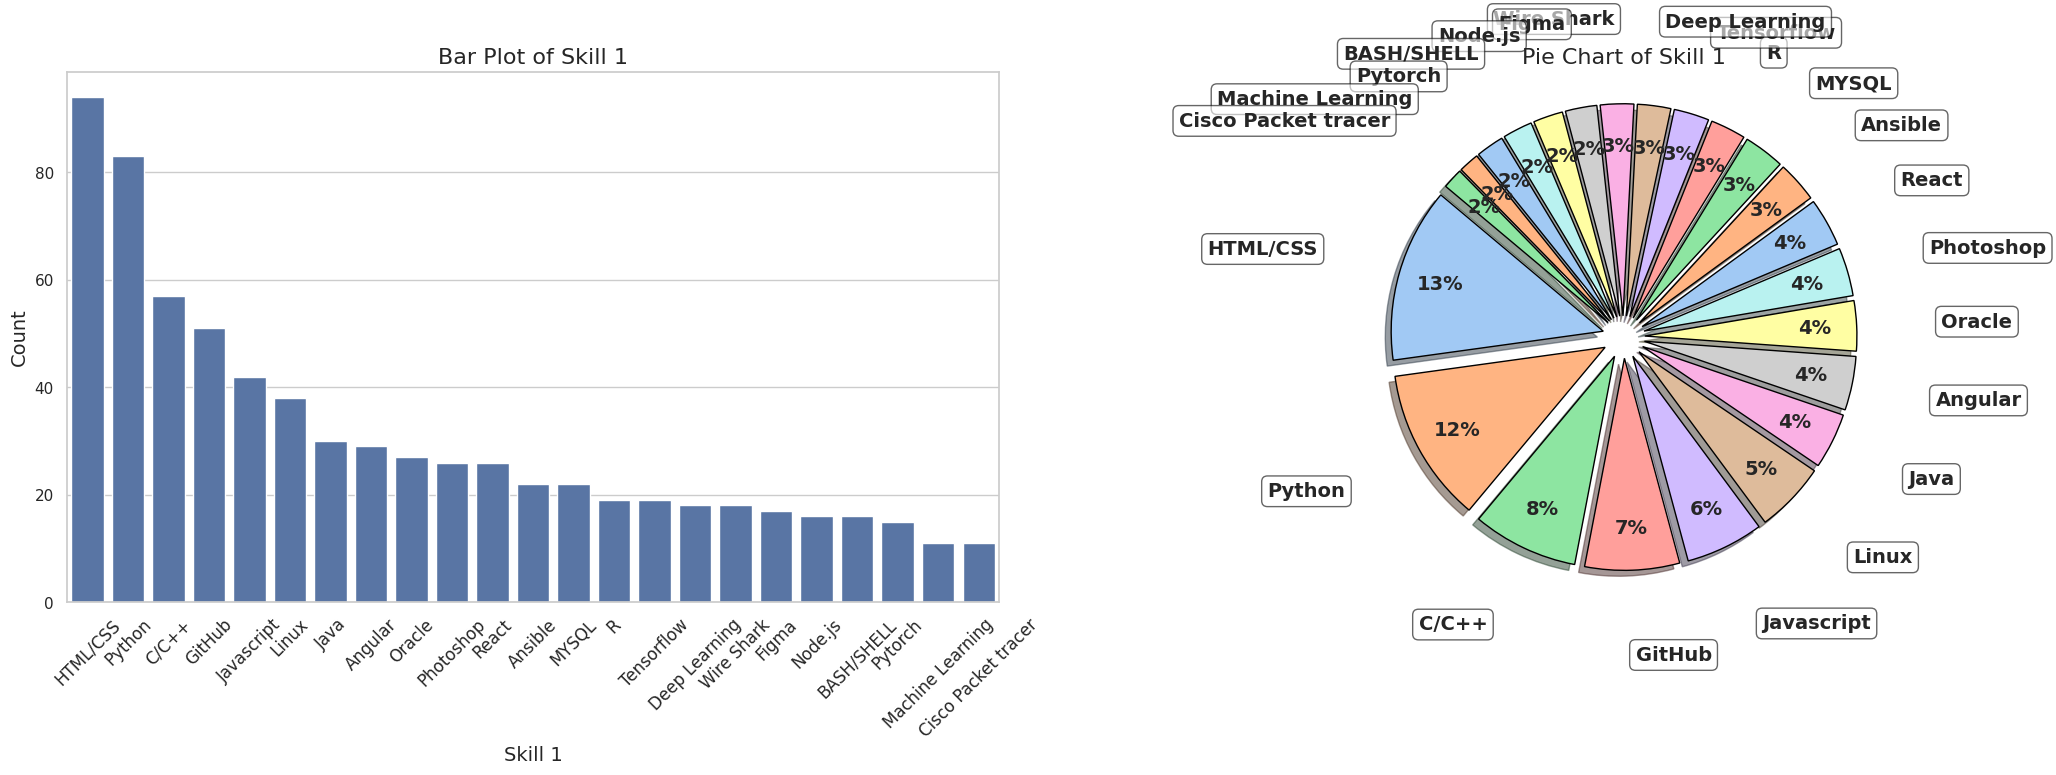

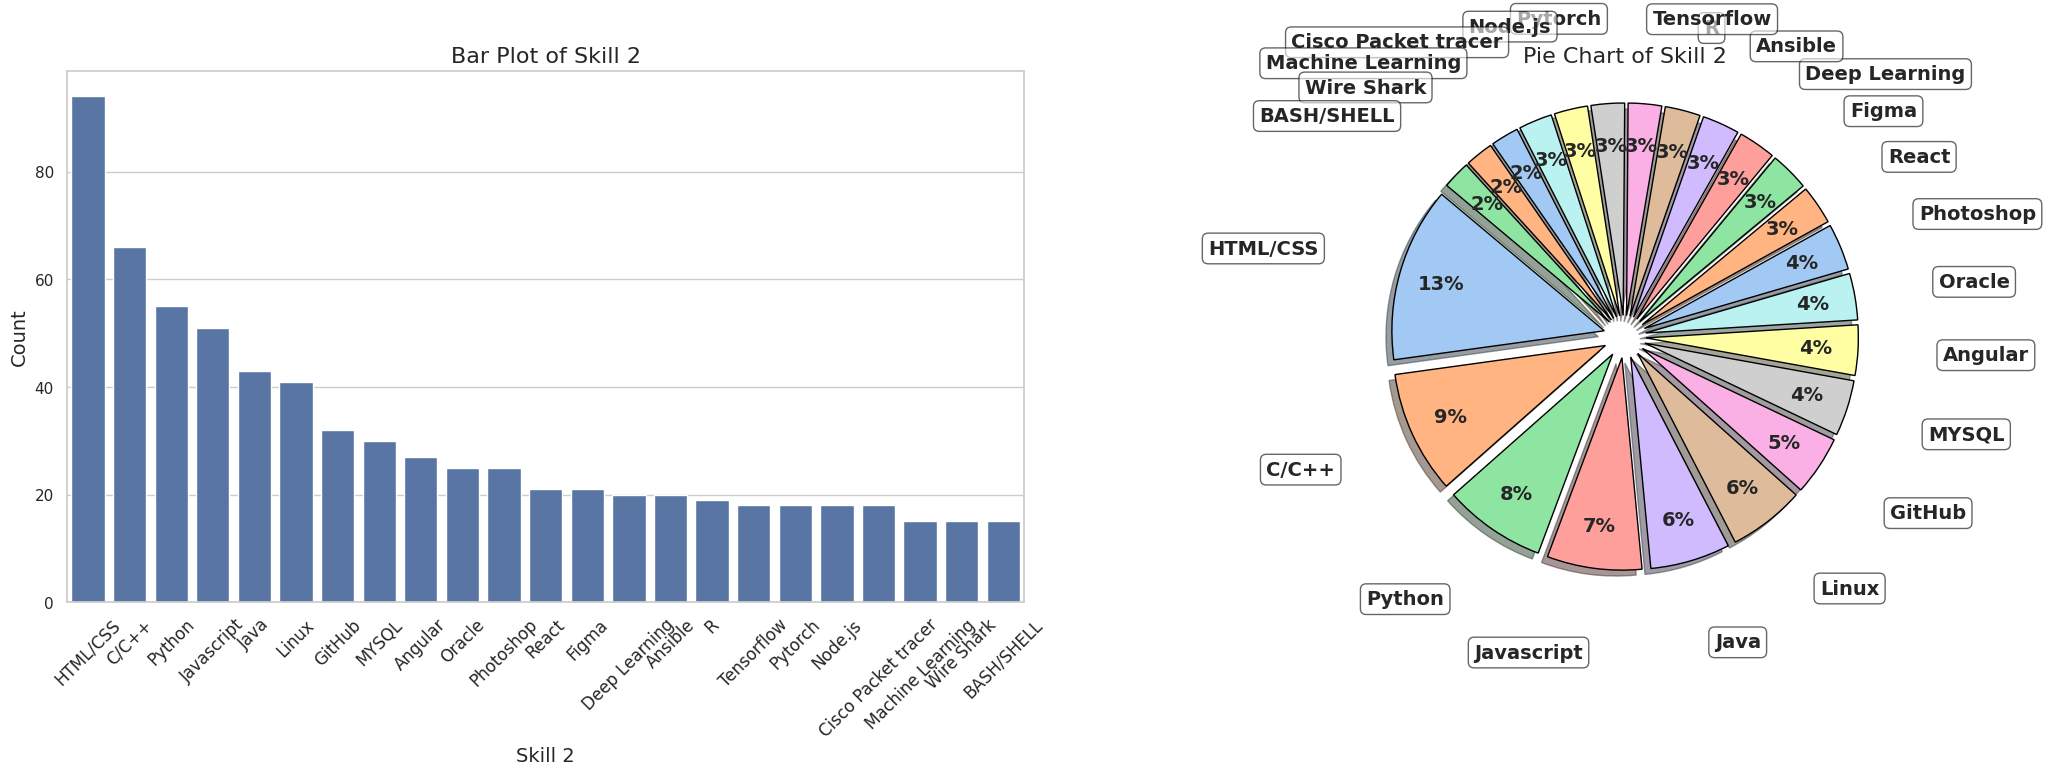

In [ ]:
for column in ['Profile', 'Skill 1', 'Skill 2']:
    plot_categorical(data, column)

👉 Distribution of all categorical variables.
- We can see that our target variable is equally distributed.
- You can see in the Skills (1 and 2) of our dataset that HTML/CSS is the   most common skill.

--------------

👉 This 2 next codes creates histograms for all numerical columns and categorical columns, visualizing their distributions to help us identify potential outliers :

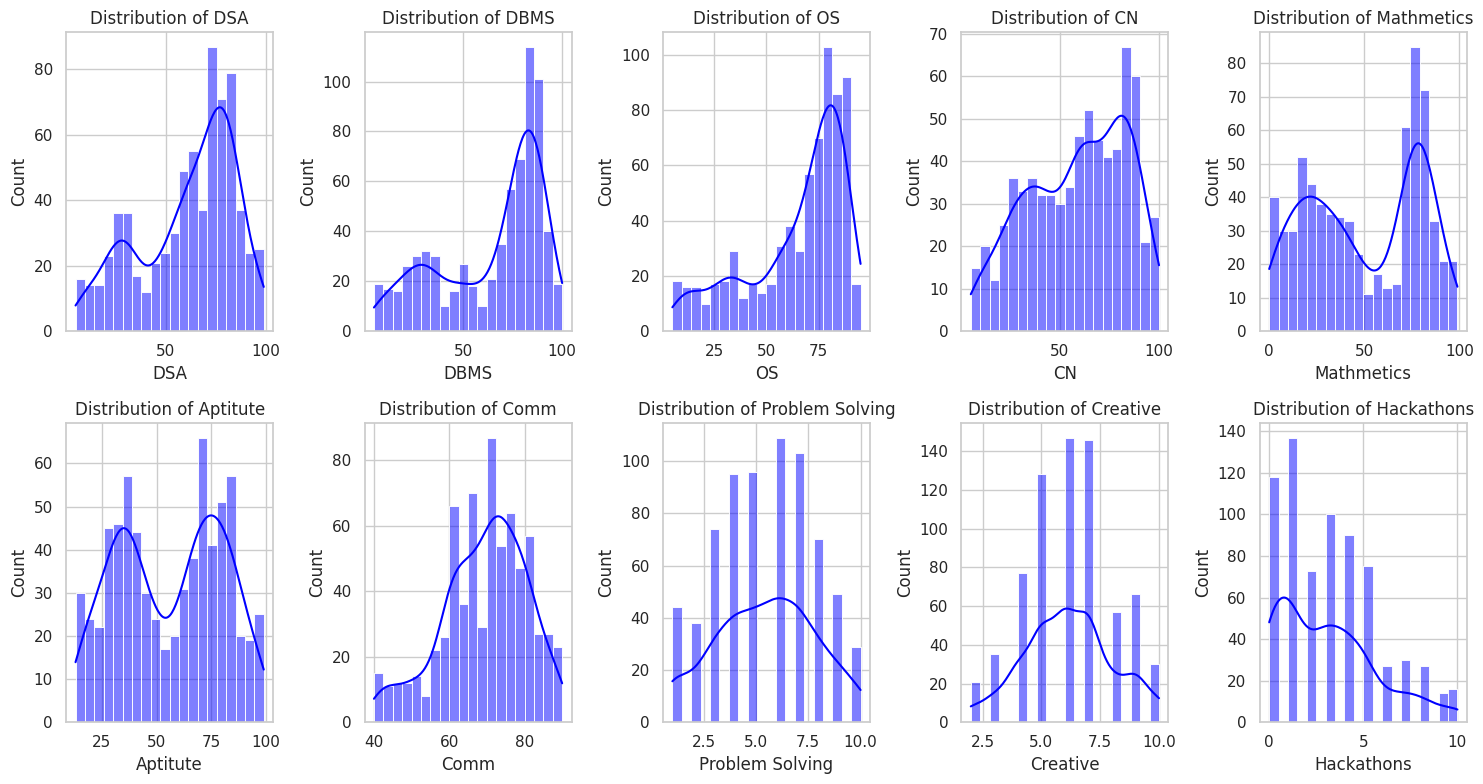

In [ ]:
numerical_columns = ["DSA", "DBMS", "OS", "CN", "Mathmetics", "Aptitute", "Comm", "Problem Solving", "Creative", "Hackathons"]
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.flatten()
for i, col in enumerate(numerical_columns):
    sns.histplot(data[col], kde=True, bins=20, ax=axes[i], color="blue")
    axes[i].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

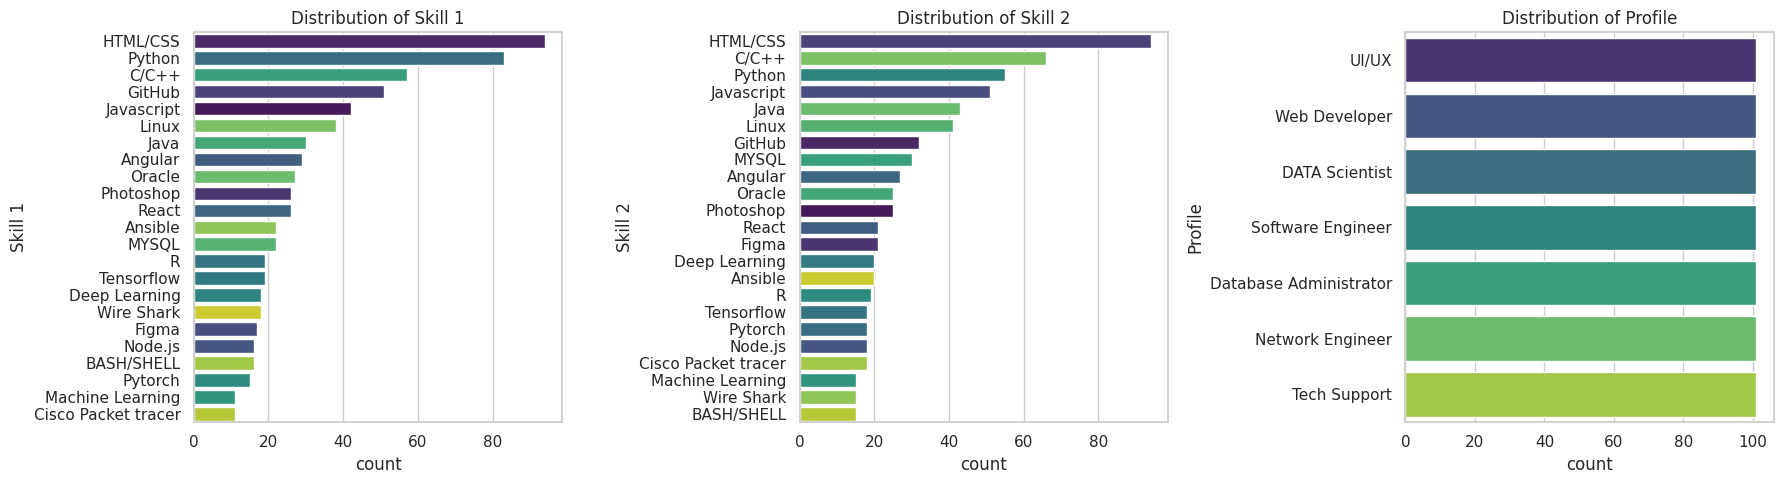

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(["Skill 1", "Skill 2", "Profile"]):
    sns.countplot(y=data[col], order=data[col].value_counts().index, ax=axes[i], hue=data[col], palette="viridis", legend=False)
    axes[i].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


👉 After visual analysis of the distribution, it can be observed that there are two-peaked distributions in some of the variables, which could indicate two performance groups or skill levels among the students.
- There are no critical outliers or unusual data, everything makes sense.

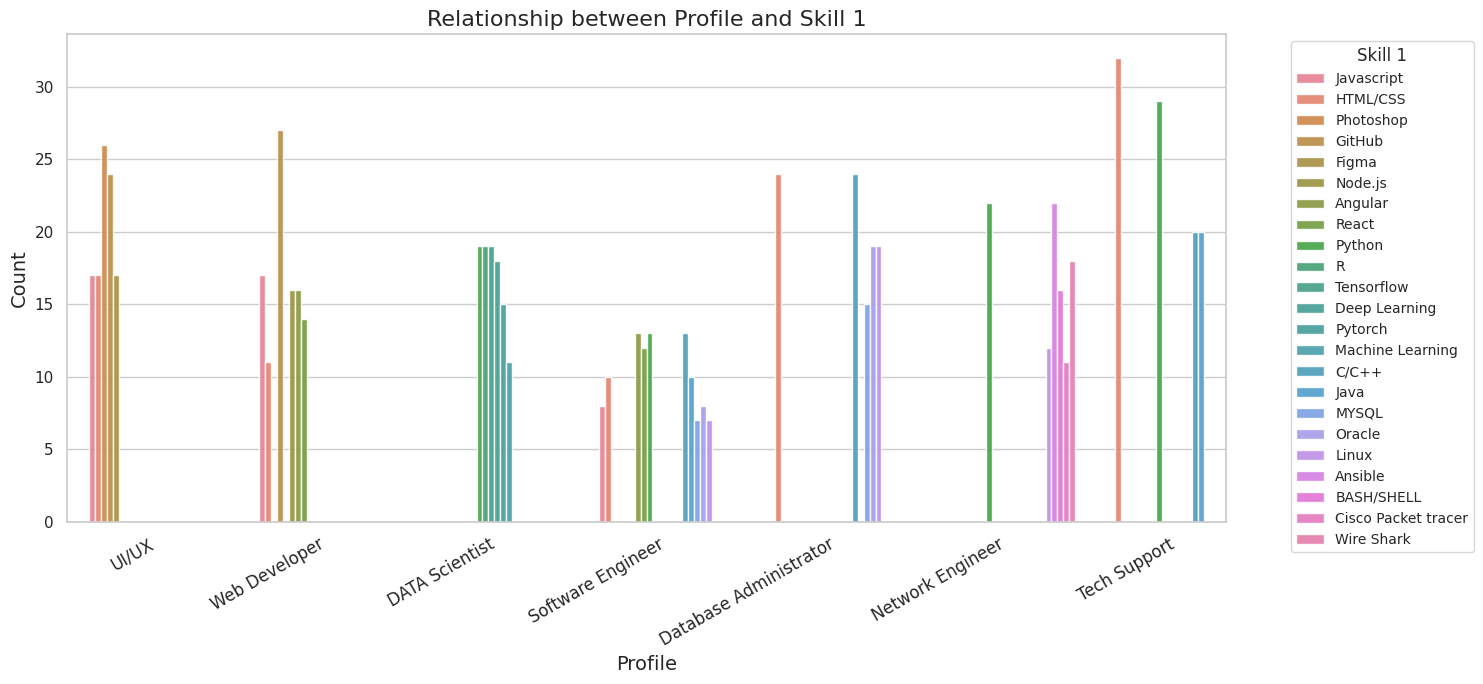

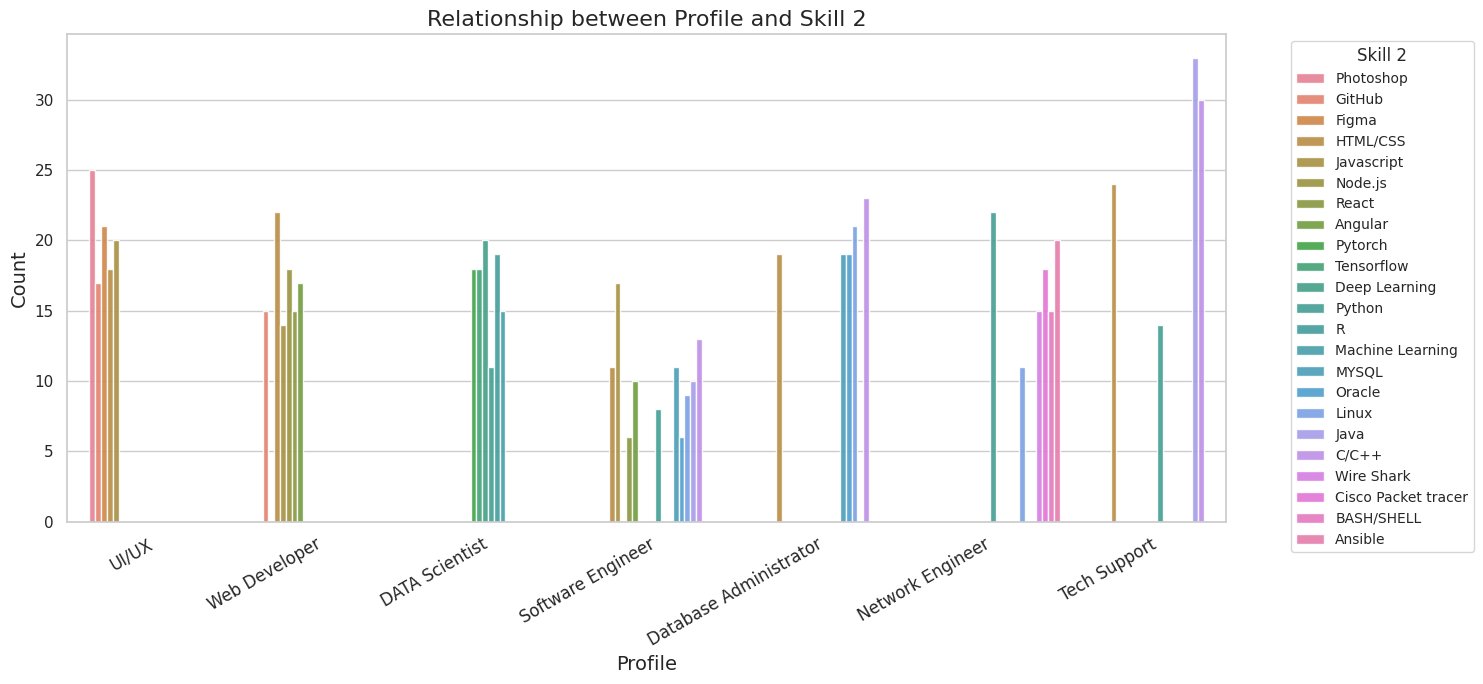

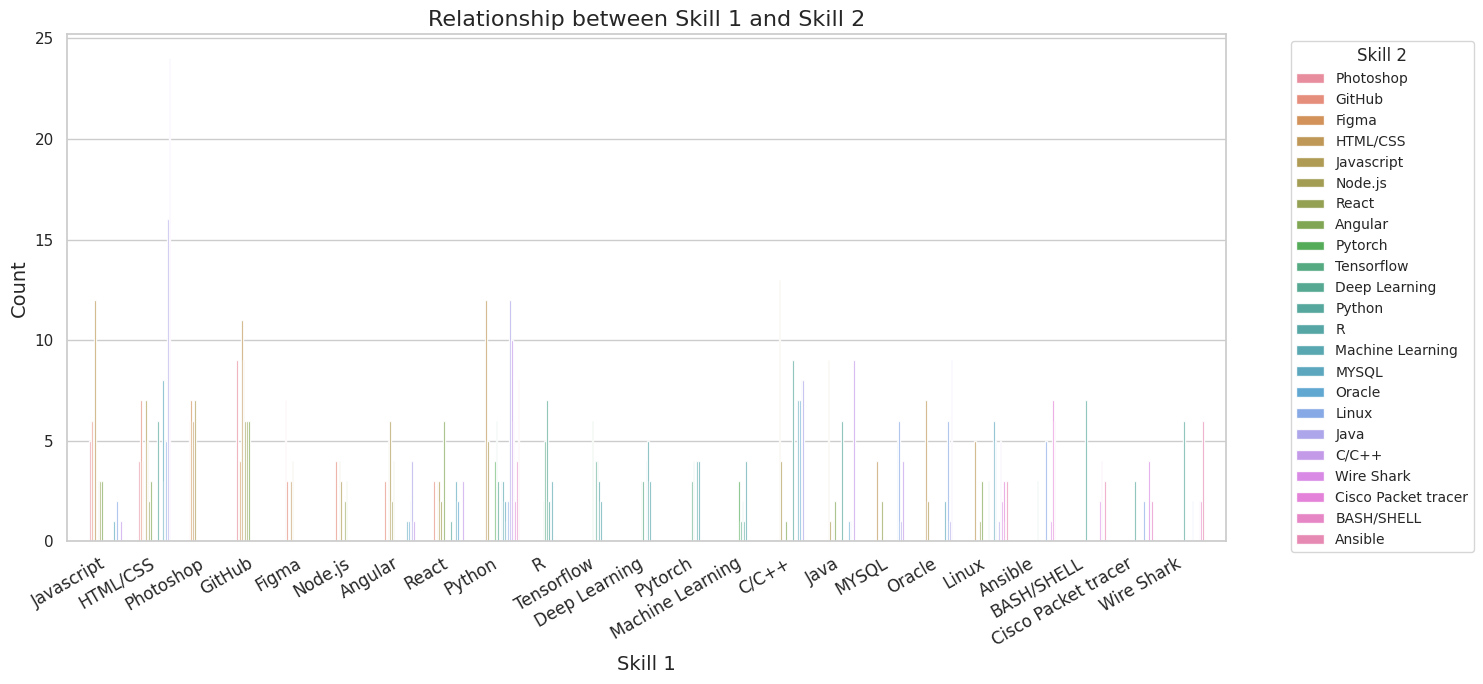

In [ ]:
cat_columns = ['Profile', 'Skill 1', 'Skill 2']

for i in range(len(cat_columns)):
    for j in range(i + 1, len(cat_columns)):
        plt.figure(figsize=(15, 7))
        ax = sns.countplot(
            x=cat_columns[i],
            hue=cat_columns[j],
            data=data,
            dodge=True,
            alpha=0.9
        )
        plt.title(f'Relationship between {cat_columns[i]} and {cat_columns[j]}', fontsize=16)
        plt.xlabel(cat_columns[i], fontsize=14)
        plt.ylabel("Count", fontsize=14)
        plt.xticks(rotation=30, ha="right", fontsize=12)
        plt.margins(x=0.02)
        plt.legend(title=cat_columns[j], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
        plt.tight_layout()
        plt.show()

👉 Relationships between every Catgorical columns:
- The script compares the category columns ("Skill 1", "Skill 2", and "Profile") against each other.
- Each graph shows the distribution (number of occurrences) of the first category (cat_columns[i]) with the second category (cat_columns[j]) represented using different colors.
- In this way, it is possible to identify relationships between the different categories.

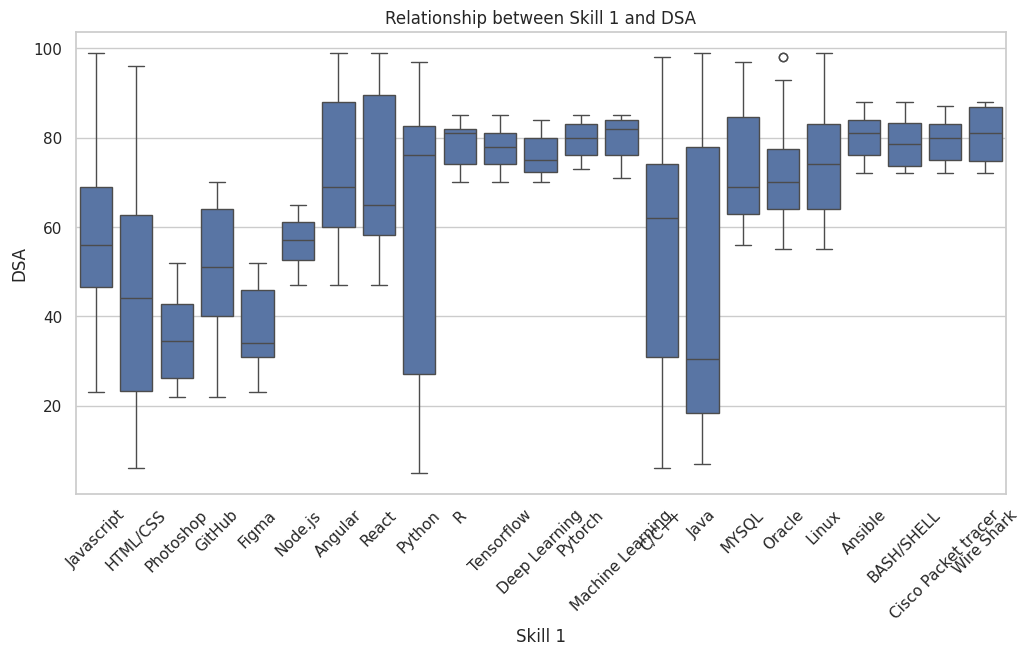

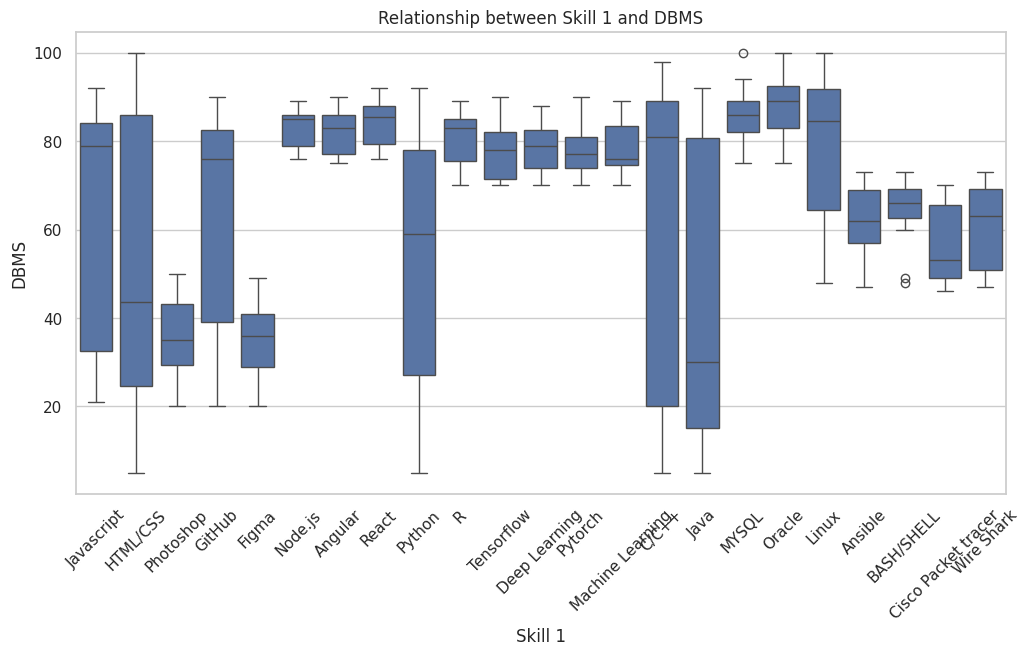

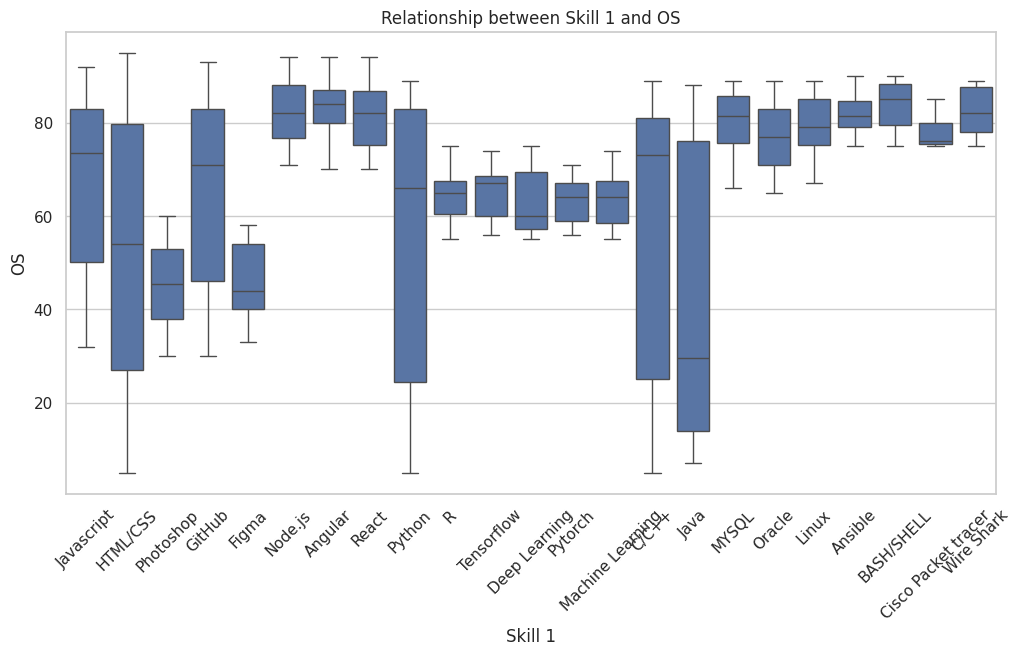

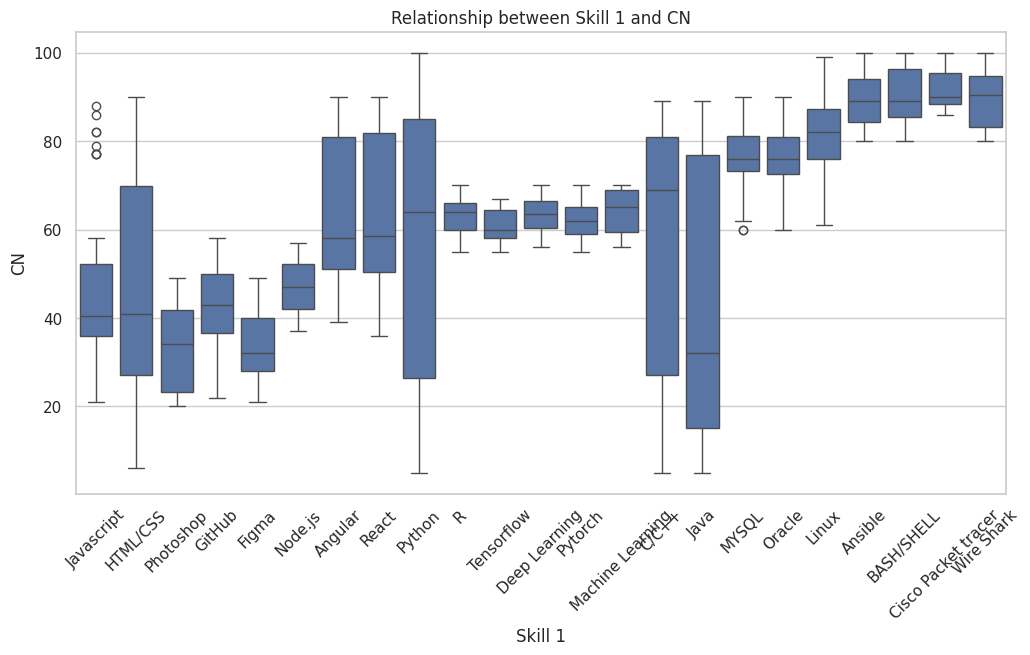

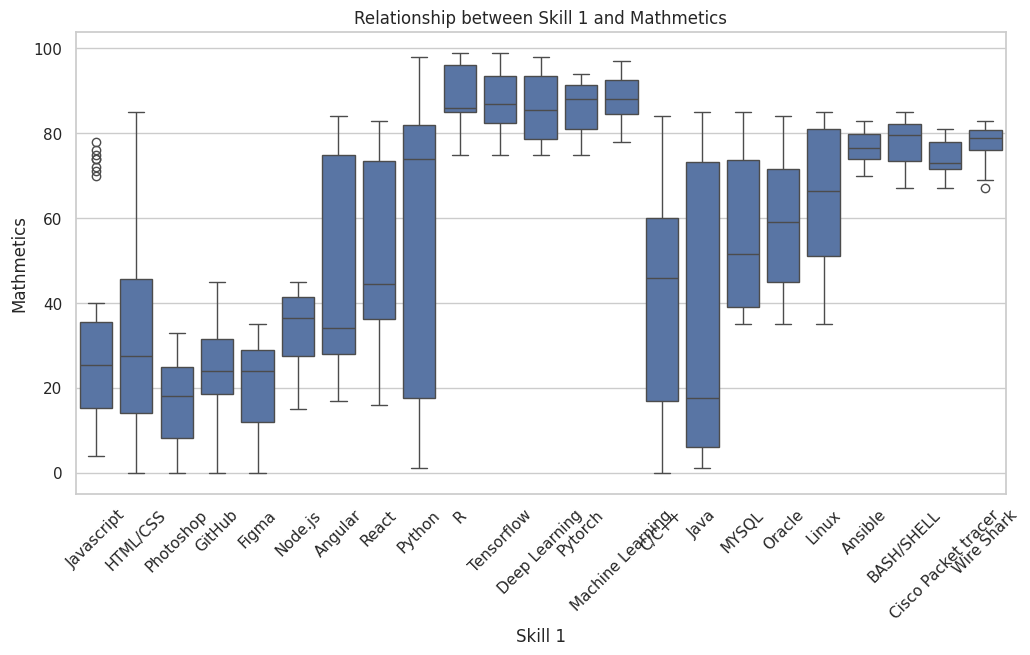

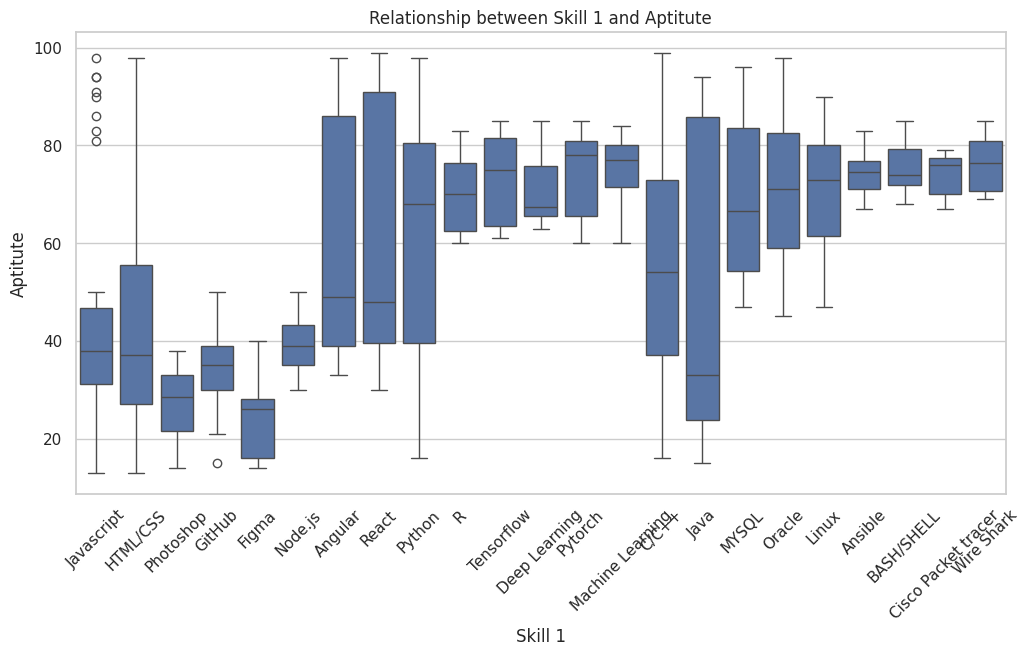

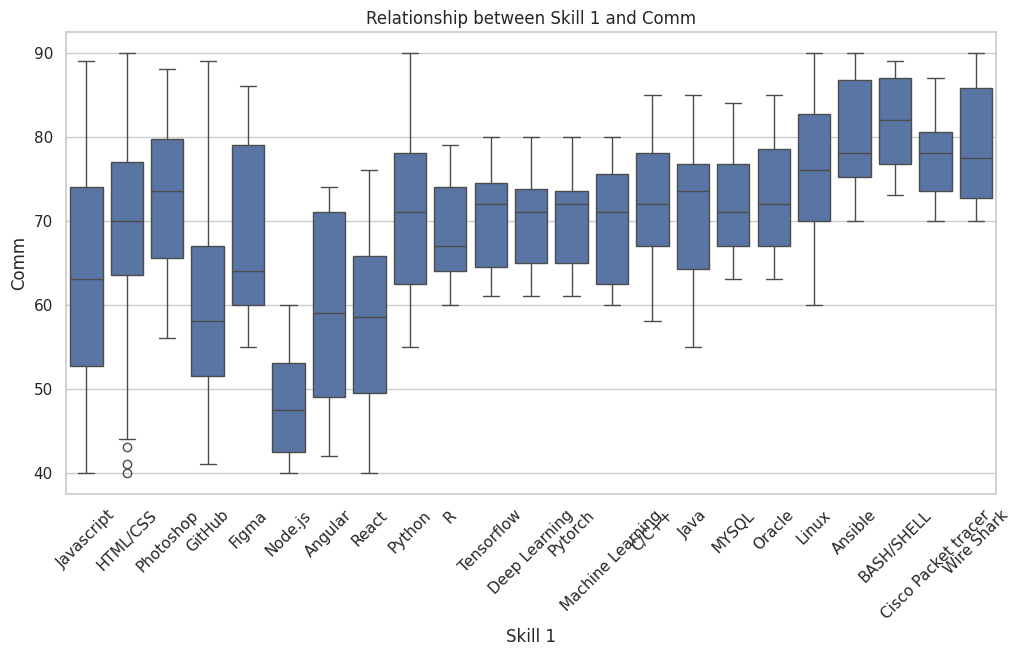

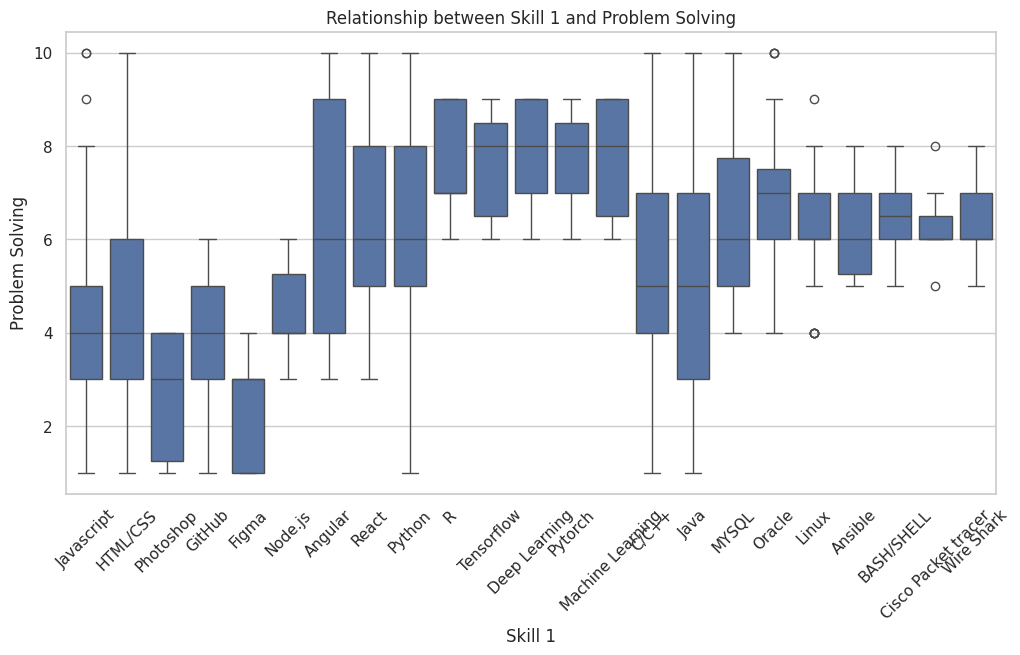

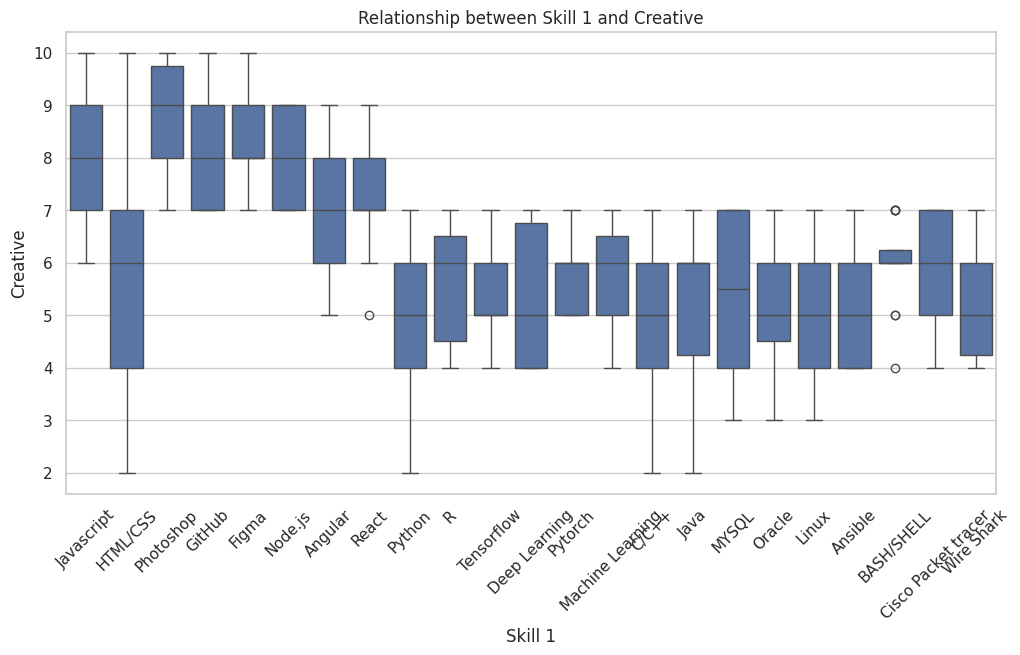

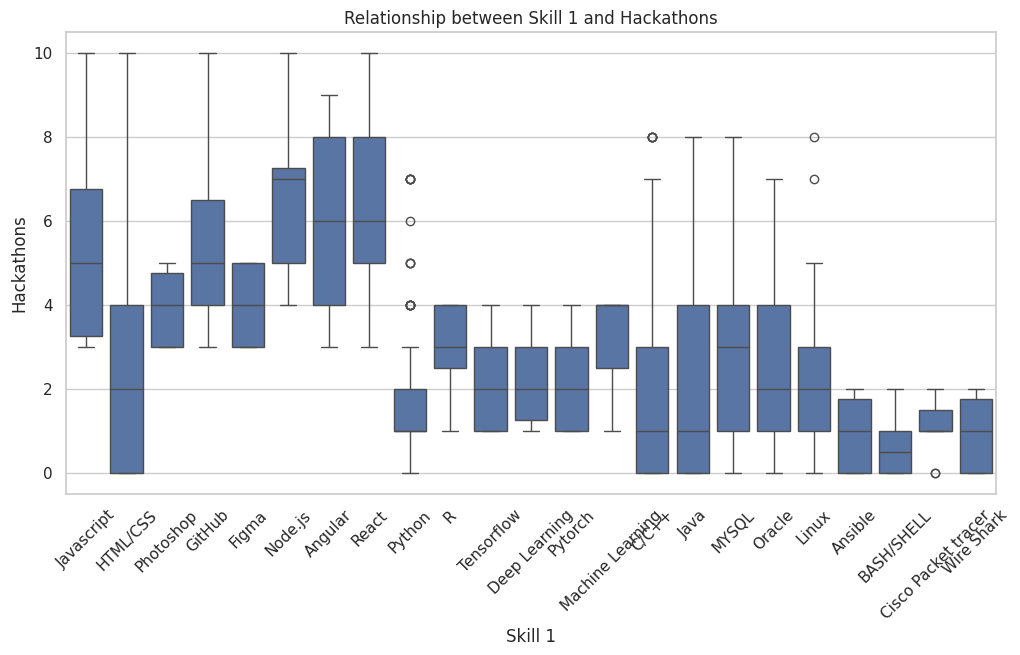

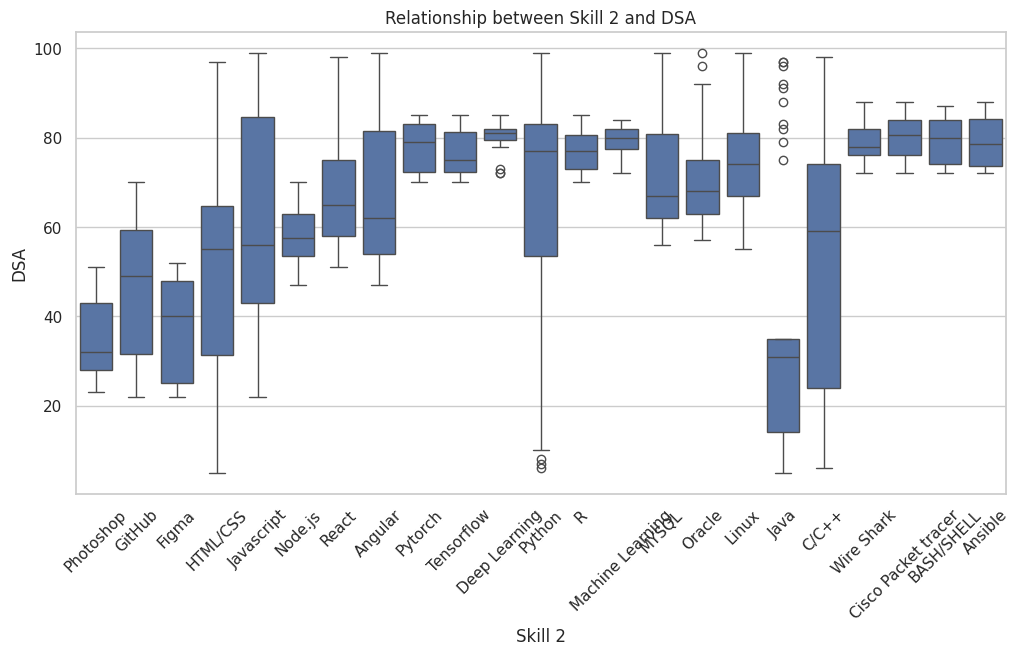

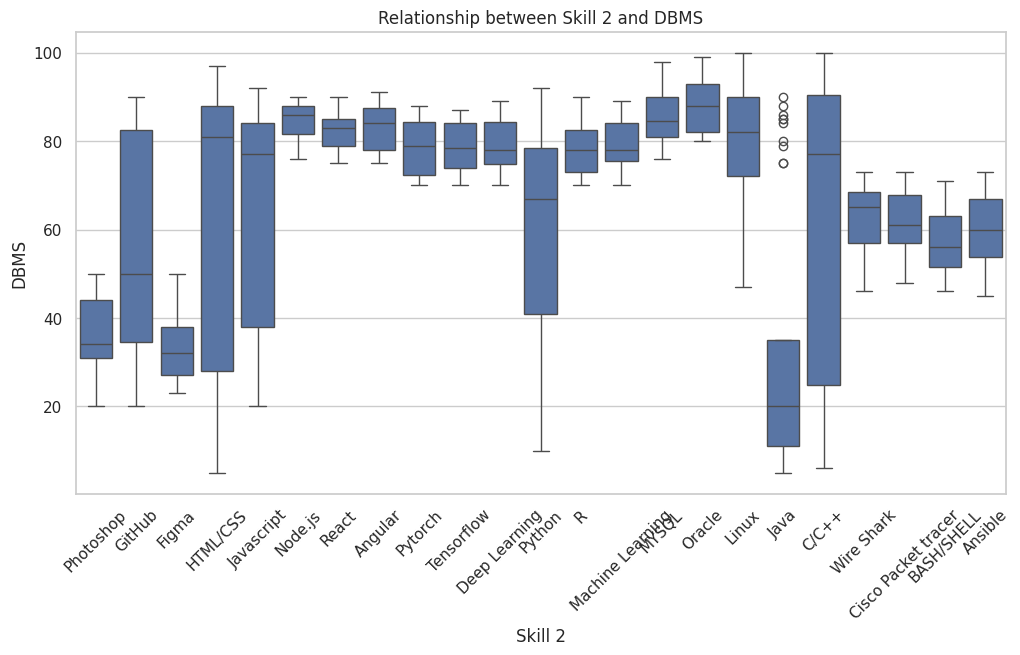

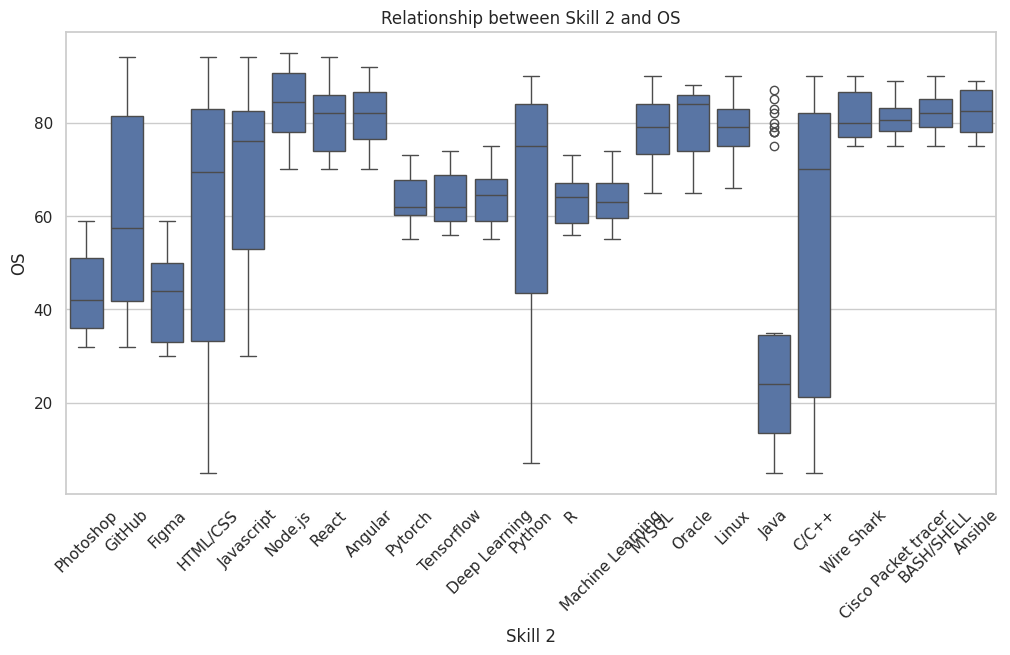

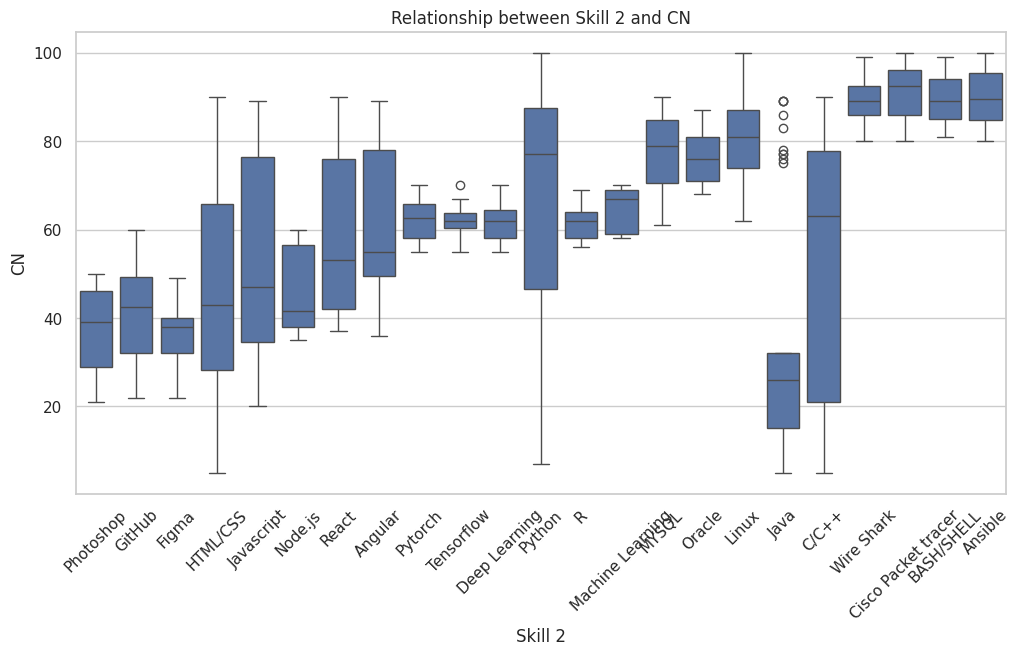

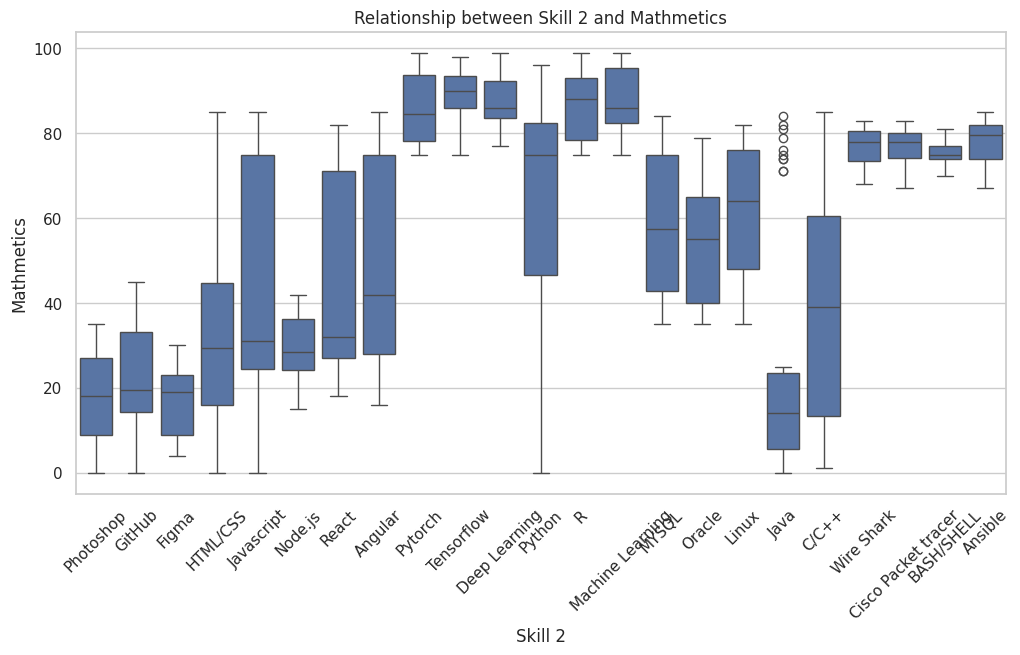

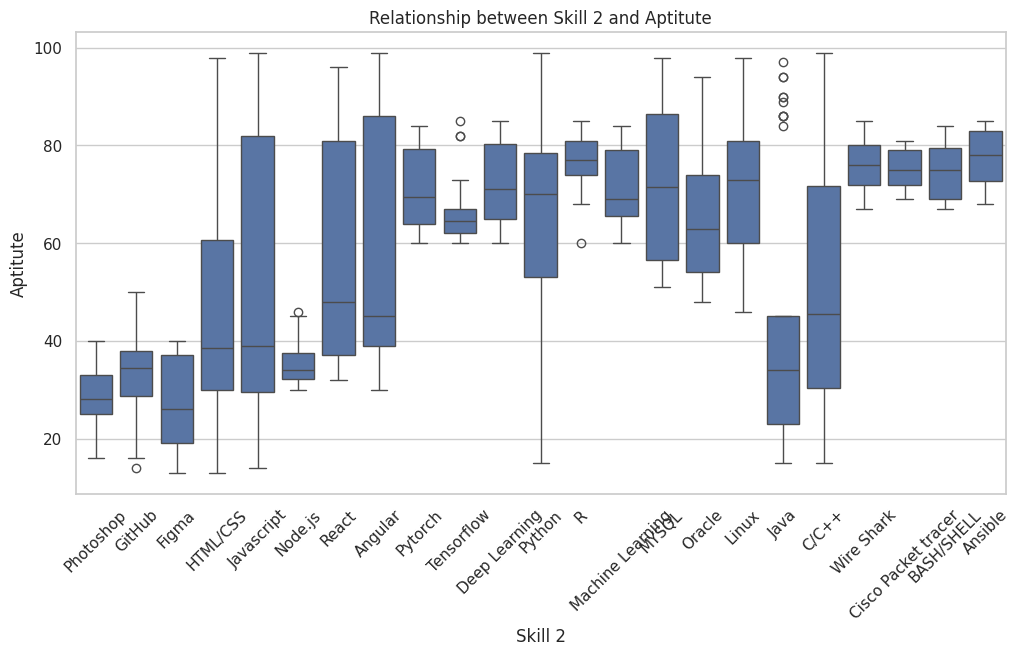

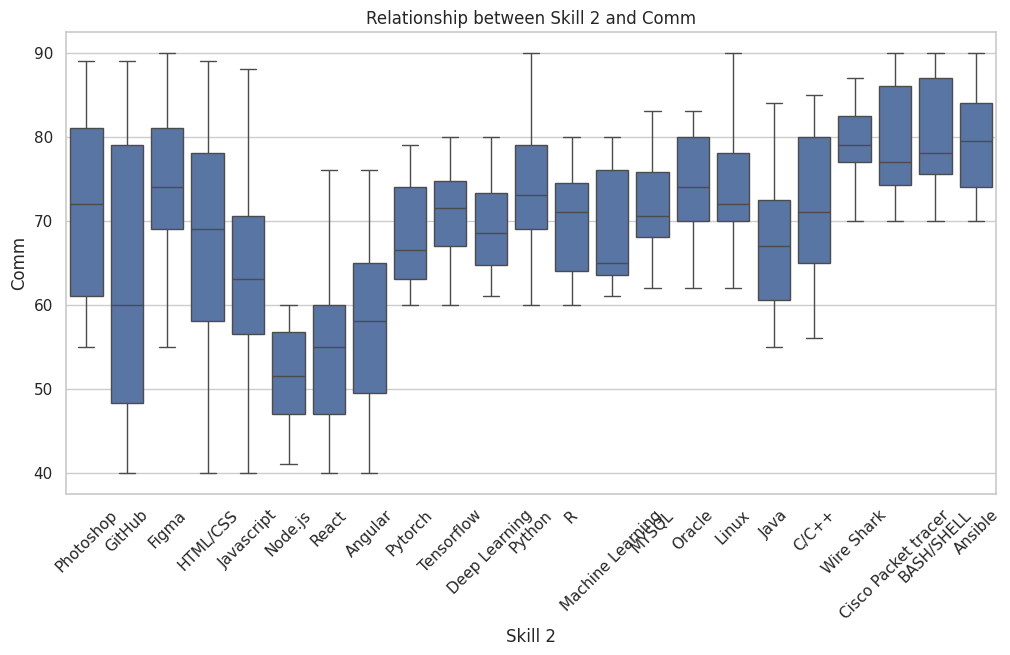

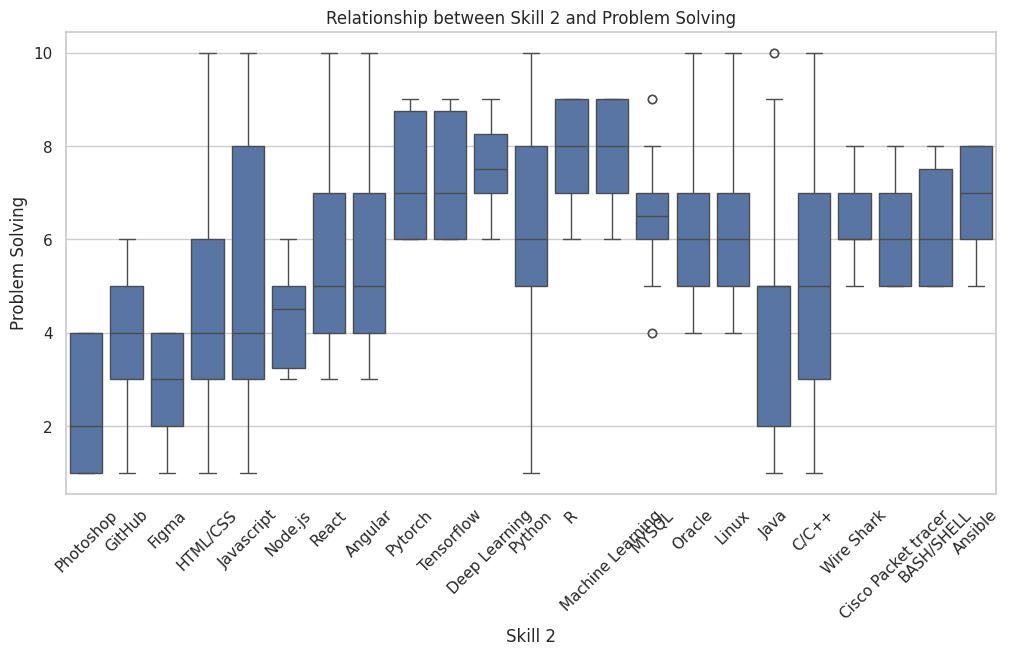

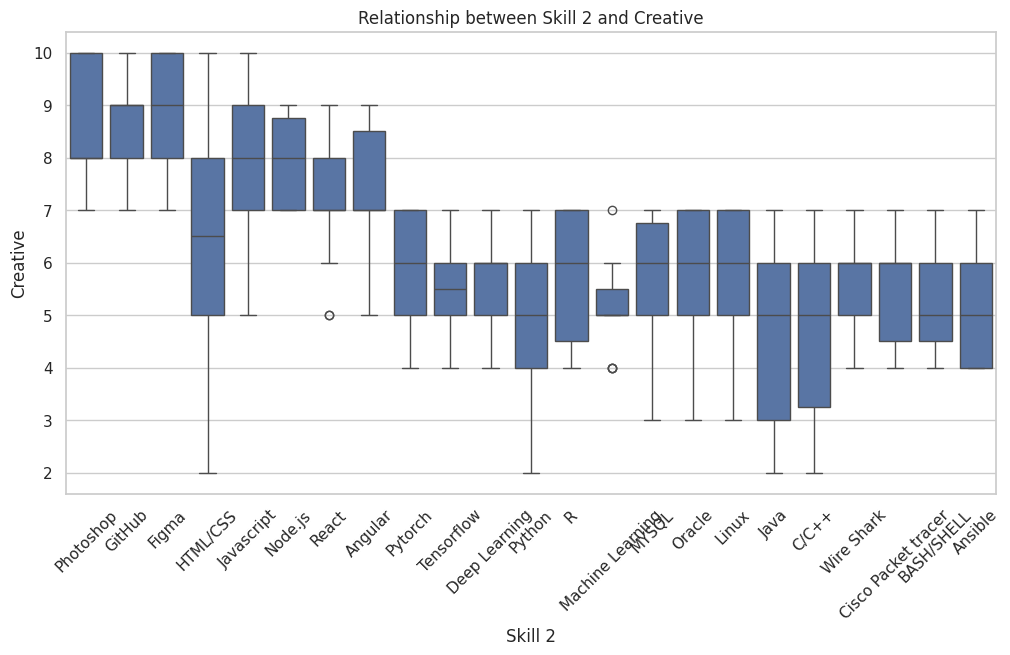

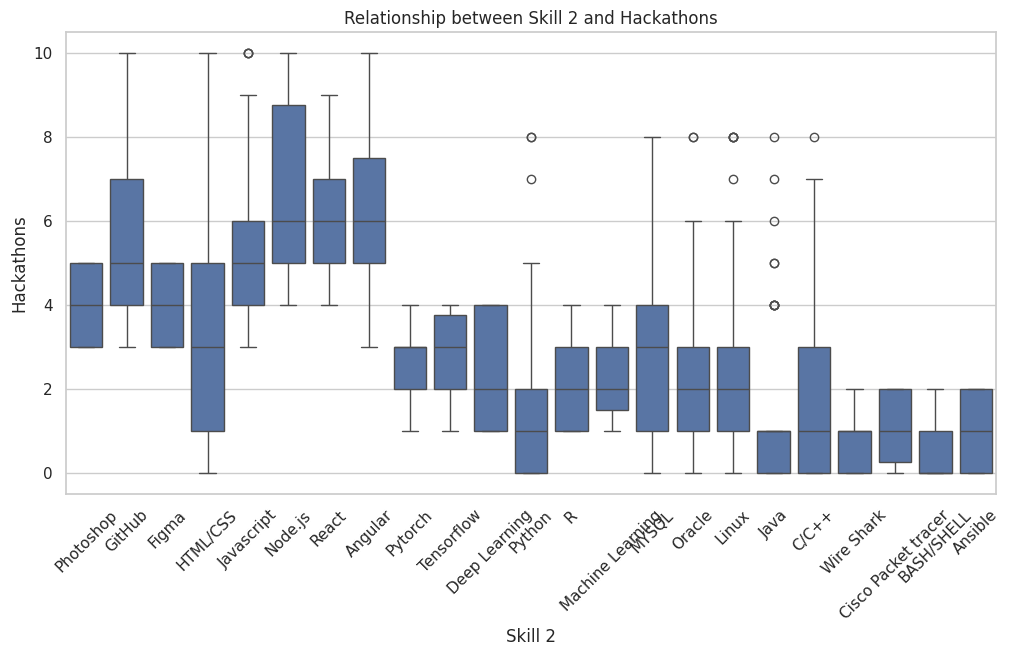

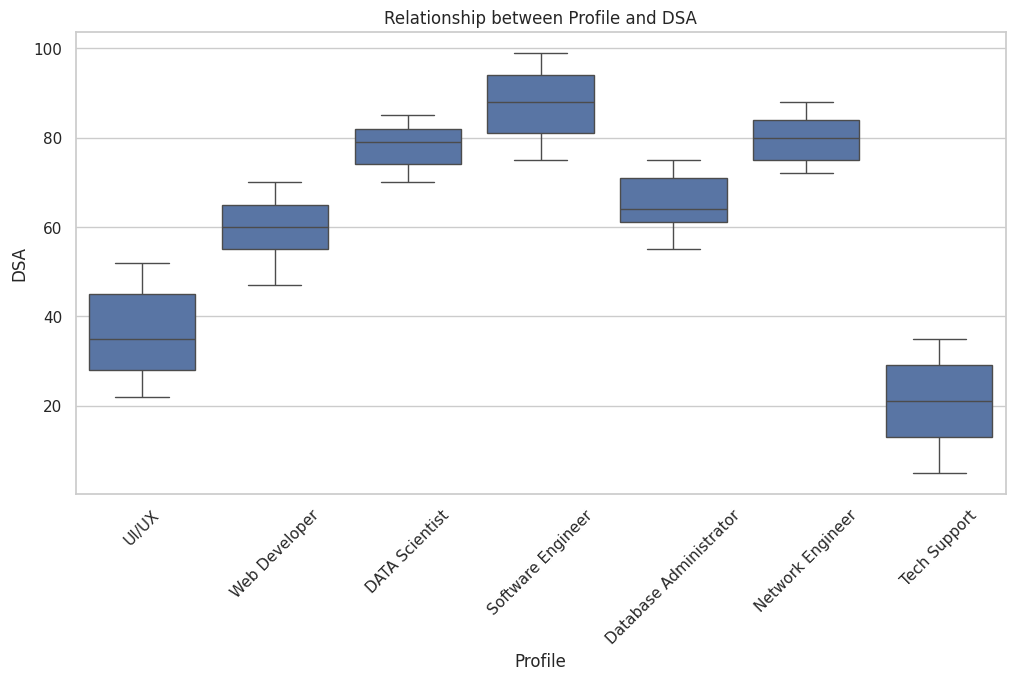

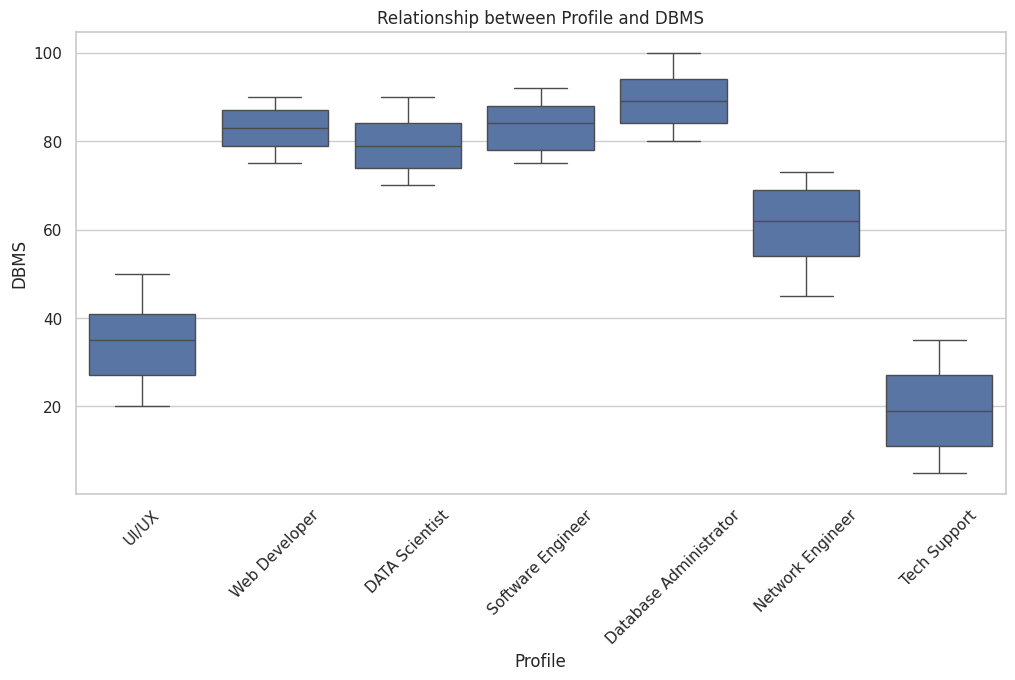

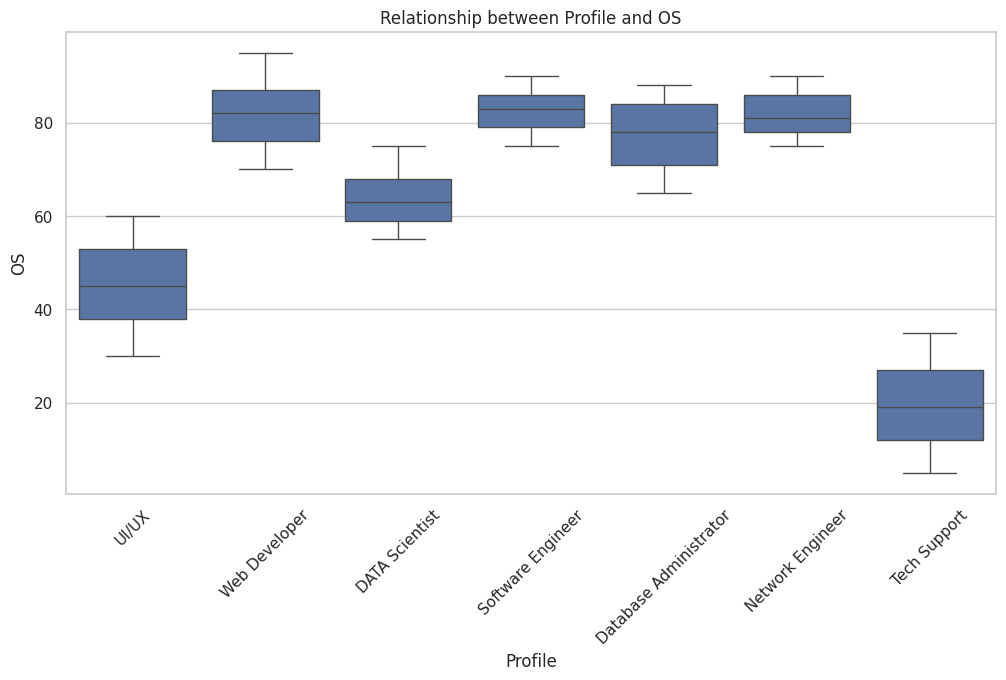

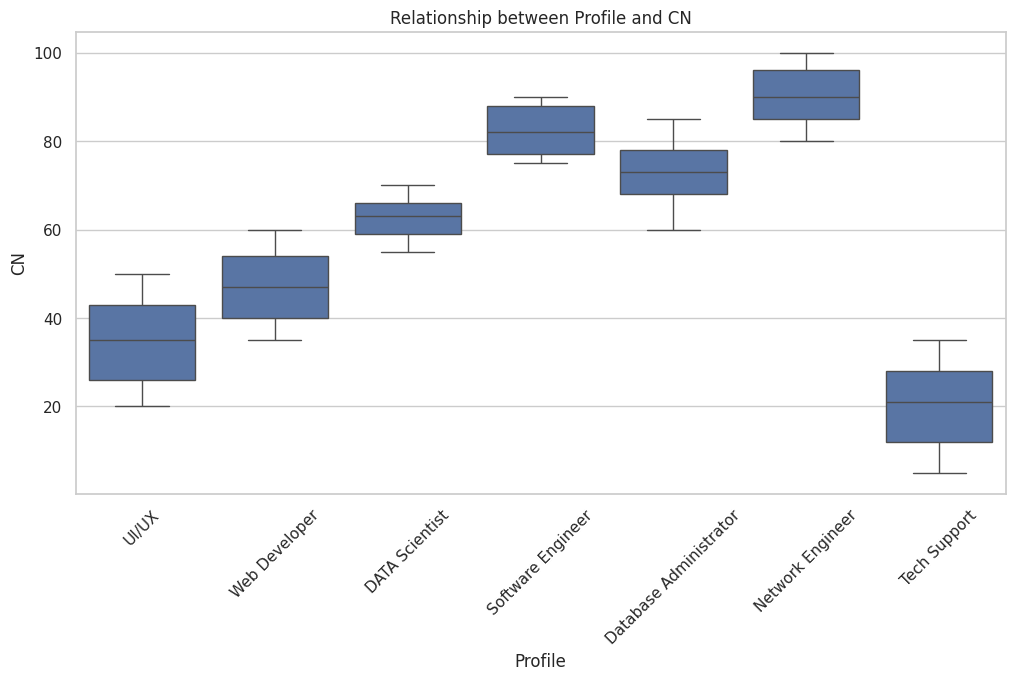

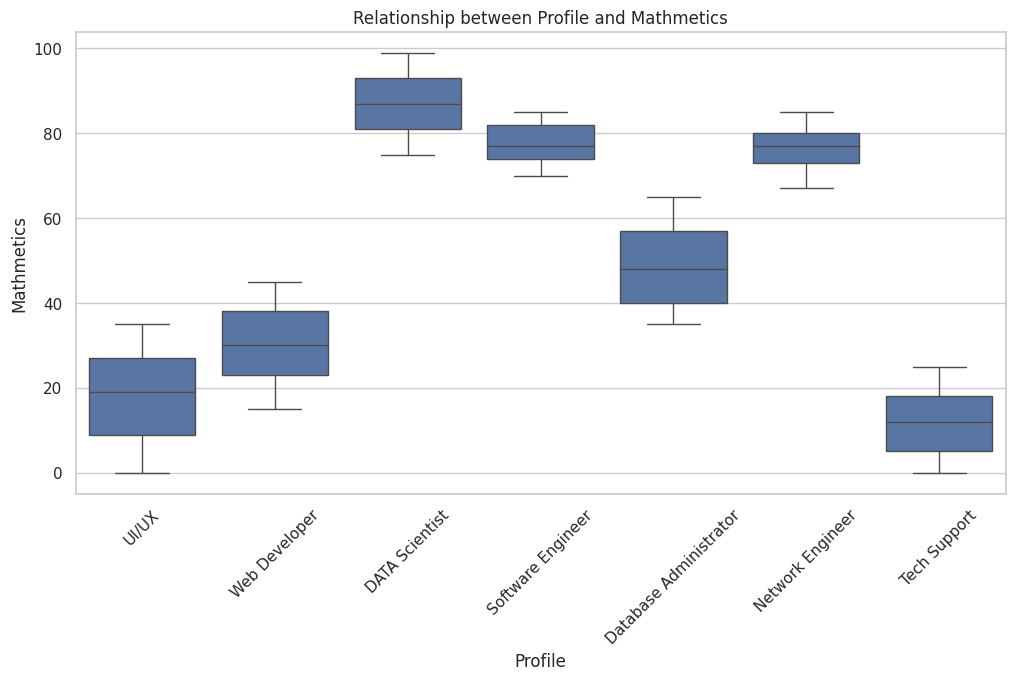

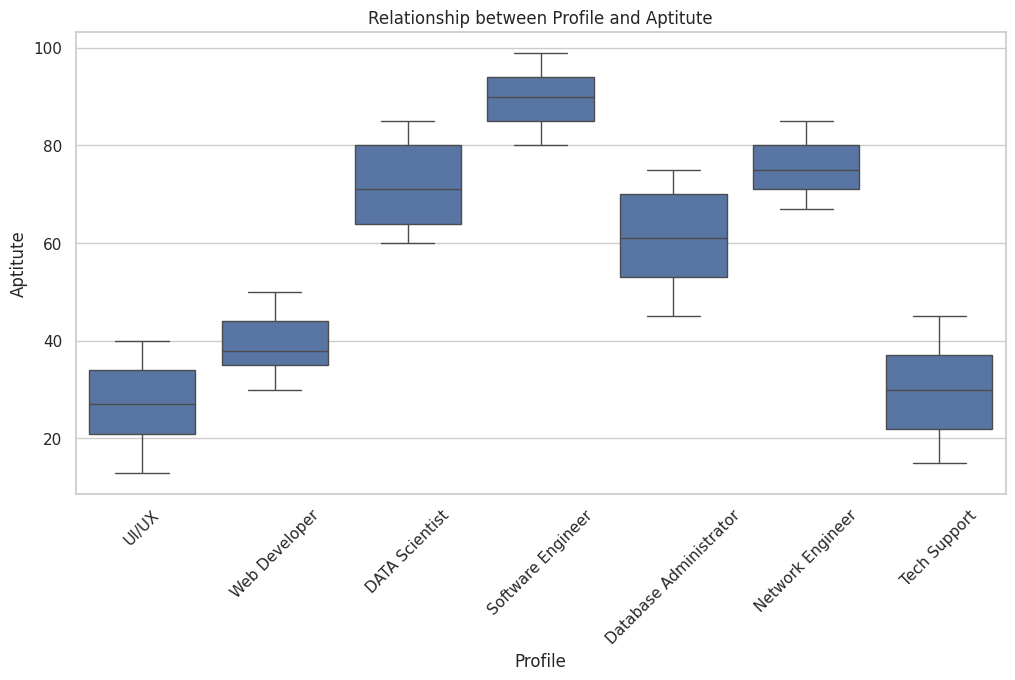

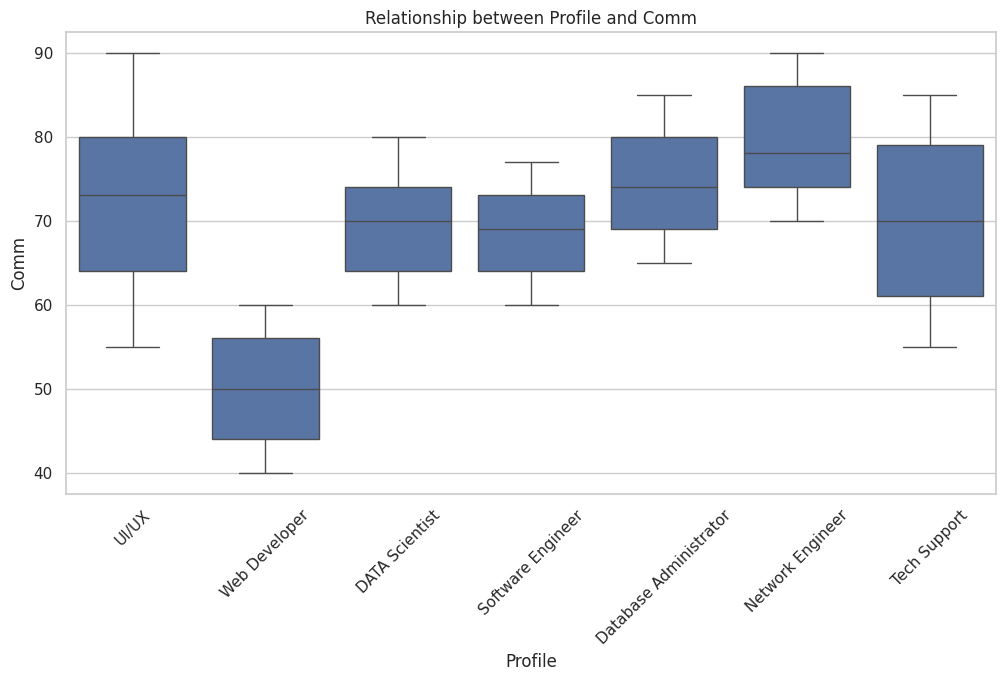

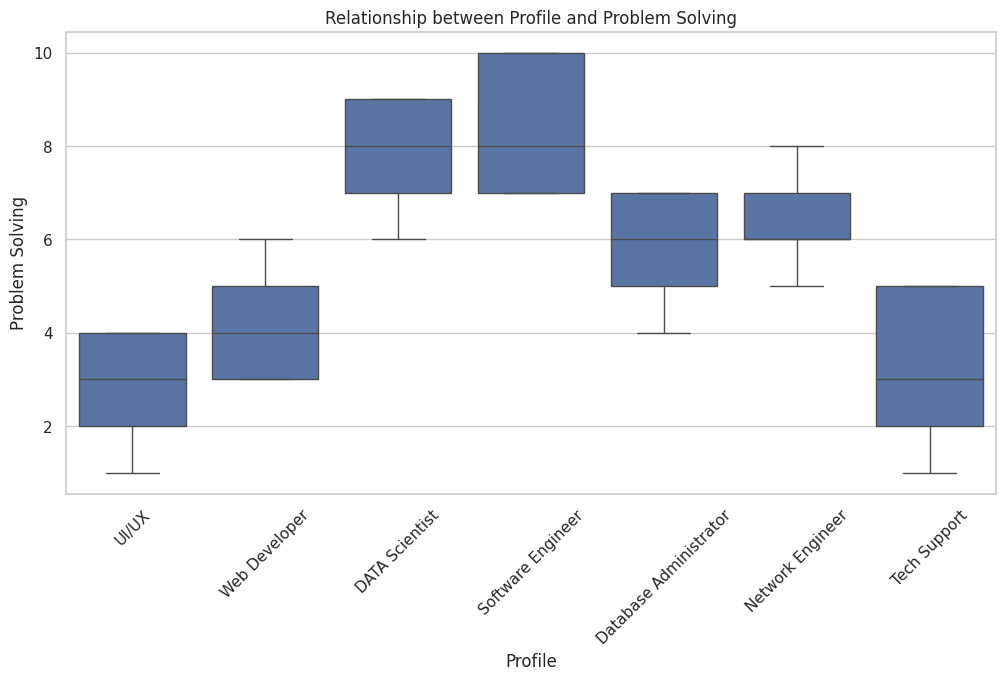

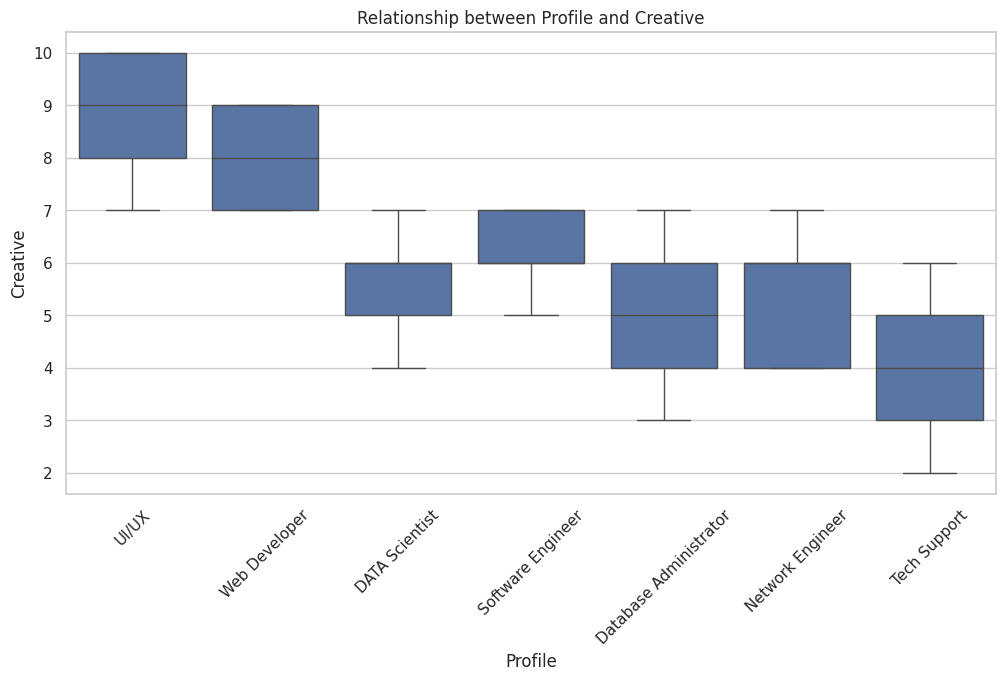

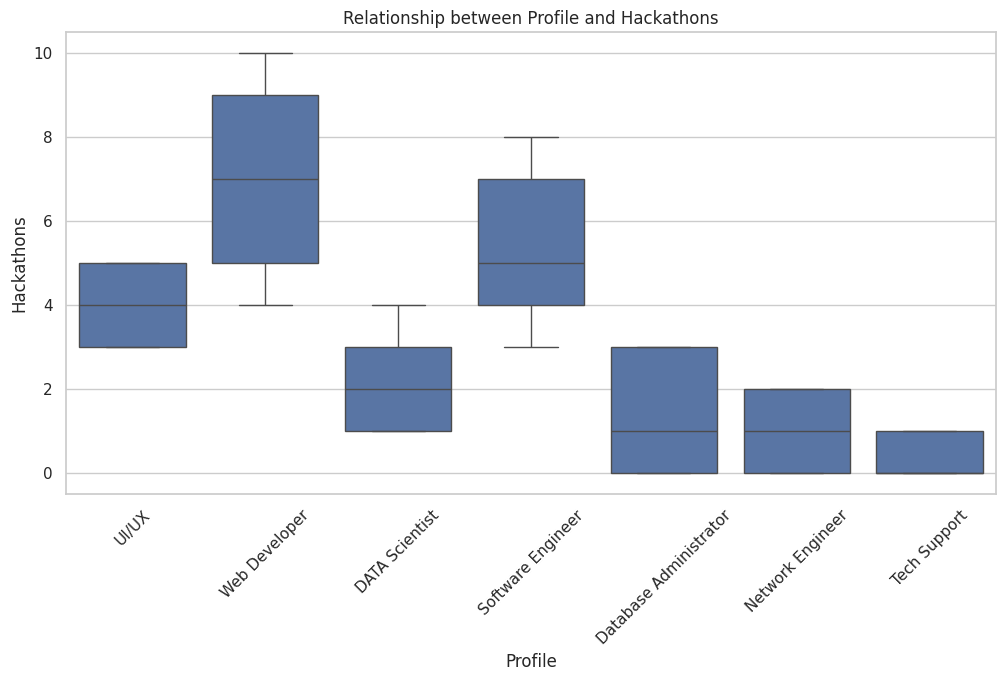

In [ ]:
cat_columns = ['Skill 1', 'Skill 2', 'Profile']

# Relationship plots between categorical columns and numerical columns.
numerical_columns = ['DSA', 'DBMS', 'OS', 'CN', 'Mathmetics', 'Aptitute', 'Comm', 'Problem Solving', 'Creative', 'Hackathons']

for cat_col in cat_columns:
    for num_col in numerical_columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x=cat_col, y=num_col, data=data)
        plt.title(f'Relationship between {cat_col} and {num_col}')
        plt.xticks(rotation=45)
        plt.show()

👉 Skill 1 vs. DSA:
DSA levels vary by skill; students with skills like React and Python show lower scores on average, while students with skills like Machine Learning and Linux show higher scores.

👉 Skill 1 vs. DBMS:
DBMS scores are low among students with Front-end skills (e.g. HTML/CSS, Figma), while Back-end and Data skills (e.g. Oracle, MYSQL) show higher scores.

👉 Skill 1 vs. OS:
Students with skills like Linux, Ansible, and Cisco Packet Tracer show high scores in Operating Systems, while students with creative skills like Photoshop and Figma show low scores.

👉 Skill 1 vs. CN:
CN scores are particularly high among students with communication and networking skills (Wire Shark, Cisco), while skills like HTML/CSS and Figma are associated with lower scores.

👉 Skill 1 vs. Mathematics:
Students with skills like R and Deep Learning show high math scores, while skills like JavaScript and GitHub show lower math scores.

👉 Skill 1 vs. Aptitude:
Technical and data analysis skills (like Angular and R) are associated with high Aptitude skills, while design skills (Figma, Photoshop) are associated with lower abilities.

👉 Skill 1 vs. Communication:
Advanced technical skills (like Linux, Oracle, Cisco) are associated with higher Communication levels, while Node.js and Figma show low Communication levels.

👉 Skill 1 vs. Problem Solving:
Problem solving is high among students with technology skills like Angular and React, and low among students with creative skills (Photoshop, Figma).

👉 Skill 1 vs. Creative:
Students with design skills (Photoshop, Figma) show very high levels of creativity, while students with purely technical skills (BASH/SHELL, Ansible) show lower levels of creativity.

👉 Skill 1 vs. Hackathons:
Students with Web and App Development skills (Angular, React) participate more in Hackathons, while students with Data Science skills (Python, R) participate less.

-----------------------

👉 Skill 2 vs. DSA:
Skills like Machine Learning and Java are associated with lower DSA scores, while skills like Oracle, Linux, and Ansible show higher DSA scores.

👉 Skill 2 vs. DBMS:
Back-end and Database skills like Oracle, MySQL, and Linux are associated with significantly higher DBMS scores, while Java is associated with lower scores.

👉 Skill 2 vs. OS:
OS scores are higher for students with technical networking skills (Cisco, Wire Shark), and lower for those with Java and HTML/CSS skills.

👉 Skill 2 vs. CN:
Skills like Cisco Packet Tracer and Wire Shark show particularly high CN scores, in contrast to Java and Figma skills that have lower scores.

👉 Skill 2 vs. Mathematics:
Data and data analysis skills (Deep Learning, Tensorflow, R) are associated with higher math scores, while design skills like Photoshop and Figma are associated with lower math scores.

👉 Skill 2 vs. Aptitude:
Front-end development skills like Angular and React are associated with high Aptitude levels, while Photoshop and Figma are associated with relatively low Aptitude levels.

👉 Skill 2 vs. Communication:
Networking and communication skills (like Wire Shark and Cisco) and technical skills like Linux and Ansible are associated with high Communication levels, while Node.js is associated with low Communication levels.

👉 Skill 2 vs. Problem Solving:
Students with skills like Angular, React, and Node.js show high problem-solving abilities, while those with skills like Photoshop and GitHub show low levels of problem-solving abilities.

👉 Skill 2 vs. Creative:
Students with design skills like Photoshop and Figma show the highest levels of creativity, while technical skills like Ansible and Cisco show low levels of creativity.

👉 Skill 2 vs. Hackathons: Participation in hackathons is higher among students with Web and Front-end development skills (Node.js, React, Angular), and lower among those with Data Science skills (R, Python).

---------------

👉 Profile vs. DSA:
Software Engineers show the highest DSA scores, while Tech Support and UI/UX show low scores.

👉 Profile vs. DBMS:
Database Administrators and Software Engineers show high scores in DBMS, while UI/UX and Tech Support show significantly lower scores.

👉 Profile vs. OS:
Operating Systems (OS) scores are particularly high among Web Developers and Software Engineers, and significantly lower among Tech Support.

👉 Profile vs. CN:
Network Engineers show the highest CN scores, while Tech Support and UI/UX show the lowest scores.

👉 Profile vs. Mathematics:
Data Scientists lead in Math scores, while UI/UX and Tech Support show the lowest scores in the field.

👉 Profile vs. Aptitude:
Software Engineers show the highest Aptitude levels, while UI/UX and Tech Support show the lowest scores.

👉 Profile vs. Communication:
UI/UX and Network Engineers show high levels of communication, while Web Developers show the lowest levels.

👉 Profile vs. Problem Solving:
Software Engineers and Data Scientists show particularly high problem-solving abilities, in contrast to Tech Support and UI/UX, which score significantly lower.

👉 Profile vs. Creative:
UI/UX clearly leads in creativity, while Tech Support and Network Engineers are at the bottom of the index.

👉 Profile vs. Hackathons:
Web Developers and Software Engineers participate most actively in Hackathons, while Tech Support participates the least.

-----------------------------
👉 This Next code creates a scatter plot to visualize the relationship between DSA and DBMS scores:

👉 Profile is our target variable.

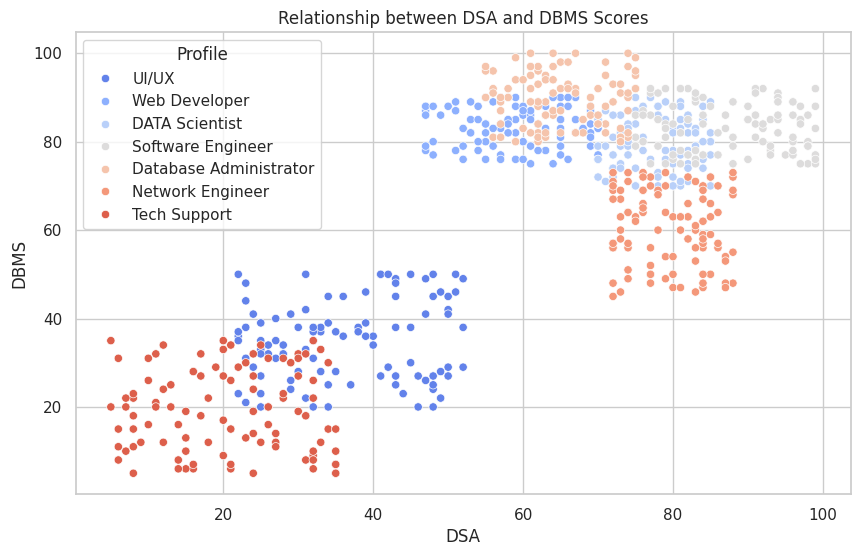

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data["DSA"], y=data["DBMS"], hue=data["Profile"], palette="coolwarm")
plt.title("Relationship between DSA and DBMS Scores")
plt.show()

👉 There is a clear distribution between the different profiles, with Software Engineer, Database Administrator, and Data Scientist showing high scores in both DSA and DBMS, while Tech Support and UI/UX show low scores in both of these areas, indicating a clear separation between technical and less technical professions.

--------------------------------
👉 generates a heatmap to show correlations between numerical features, helping identify relationships that can impact model performance:

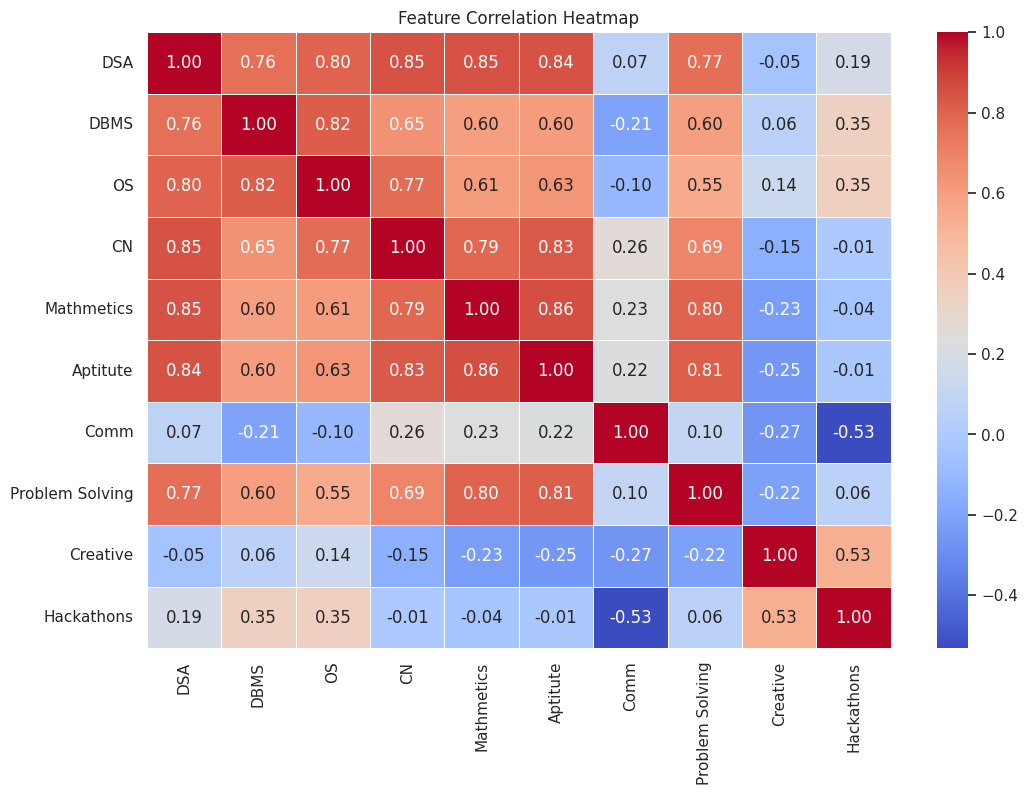

In [ ]:
numerical_columns = ["DSA", "DBMS", "OS", "CN", "Mathmetics", "Aptitute", "Comm", "Problem Solving", "Creative", "Hackathons"]

numerical_data = data[numerical_columns]

plt.figure(figsize=(12, 8))
sns.heatmap(numerical_data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

👉 There is a strong correlation between the technical and academic subjects (DSA, DBMS, OS, CN, Mathematics, Aptitude), indicating close connections between them, while Communication and Creative show a weak and even negative correlation with these variables, indicating a significant difference between technical skills and personality.

-----------------

# Step 2: Data Cleaning

👉 First, we will check if there is no null data:

In [ ]:
data.isnull().sum()

DSA                0
DBMS               0
OS                 0
CN                 0
Mathmetics         0
Aptitute           0
Comm               0
Problem Solving    0
Creative           0
Hackathons         0
Skill 1            0
Skill 2            0
Profile            0
dtype: int64

👉 Secondly, we separates the dataset into features (X) and target variable (y), where X contains all independent variables except 'Profile', and y holds the target labels (student career paths) for classification.

In [ ]:
X = data.drop(columns=['Profile'])
y = data['Profile']

👉 This code identifies the features in a dataset into numerical and categorical features:

In [ ]:
# Identify Numerical and Categorical features
numerical_features = ["DSA", "DBMS", "OS", "CN", "Mathmetics", "Aptitute", "Comm",
                      "Problem Solving", "Creative", "Hackathons"]

categorical_features = ["Skill 1", "Skill 2"]

print("Numerical and Categorical features identified.")
print(f" Numerical Features: {numerical_features}")
print(f" Categorical Features: {categorical_features}")

print(X.columns)

Numerical and Categorical features identified.
 Numerical Features: ['DSA', 'DBMS', 'OS', 'CN', 'Mathmetics', 'Aptitute', 'Comm', 'Problem Solving', 'Creative', 'Hackathons']
 Categorical Features: ['Skill 1', 'Skill 2']
Index(['DSA', 'DBMS', 'OS', 'CN', 'Mathmetics', 'Aptitute', 'Comm',
       'Problem Solving', 'Creative', 'Hackathons', 'Skill 1', 'Skill 2'],
      dtype='object')


-----------------

# Step 3: Train-test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data Split Completed!")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Data Split Completed!
X_train shape: (565, 12), y_train shape: (565,)
X_test shape: (142, 12), y_test shape: (142,)


👉 The train_test_split function from sklearn.model_selection splits the dataset into training and testing sets. In this case, 80% of the data is assigned to X_train and y_train, while 20% is assigned to X_test and y_test, ensuring that the model is trained on one part of the data and tested on another for evaluation. The random_state=42 ensures reproducibility of the split.


--------------

# Step 4 : Calculate outliers

In [ ]:
# Calculate IQR for numerical features
Q1 = X_train[numerical_features].quantile(0.25)
Q3 = X_train[numerical_features].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for non-outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter data within the bounds
non_outliers = ((X_train[numerical_features] >= lower_bound) & (X_train[numerical_features] <= upper_bound)).all(axis=1)
X_train = X_train[non_outliers]
y_train = y_train.loc[X_train.index]

print("Outliers removed using IQR method.")
print(f"Updated training set size: {X_train.shape}")

Outliers removed using IQR method.
Updated training set size: (549, 12)


👉 This code identifies and removes outliers from the training dataset using the Interquartile Range (IQR) method. It ensures that only data points within the defined non-outlier range remain in X_train and updates y_train accordingly to maintain alignment.

----------------

# Step 5 : Preprocessing Pipelines for Numerical and Categorical Features

In [ ]:
numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, ['DSA', 'DBMS', 'OS', 'CN', 'Mathmetics', 'Aptitute', 'Comm', 'Problem Solving', 'Creative', 'Hackathons']),
        ('cat', categorical_transformer, ['Skill 1', 'Skill 2',])
    ]
)

👉 This pipeline preprocesses numerical and categorical features by handling missing values (using KNNImputer and SimpleImputer), scaling numerical data (RobustScaler), and encoding categorical variables (OneHotEncoder), ensuring the dataset is properly formatted for machine learning models.

In [ ]:
feature_selection_pca = Pipeline(steps=[
    ('feature_selection', SelectKBest(score_func=f_classif, k=5)),
    ('pca', PCA(n_components=2))
])

👉 k=5 was chosen because increasing to k=8 or k=10 (for example) made no significant difference. This shows that 5 features are enough to capture the essential information efficiently.

👉 PCA with 2 components was chosen because it preserved most of the important information without adding unnecessary complexity.

In [ ]:
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection_pca', feature_selection_pca)
])

👉 The full pipeline combines preprocessing (preprocessor) and feature selection with PCA (feature_selection_pca) into a single pipeline, ensuring consistent data transformation before training a model.

-------------

# Step 6 : Transform Data

In [ ]:
# Dividing the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_transformed = full_pipeline.fit_transform(X_train, y_train)
X_test_transformed = full_pipeline.transform(X_test)

👉 This code splits the dataset into training and testing sets, then applies the full_pipeline to transform the training data (fit_transform) and applies the same transformations to the test data (transform) to ensure consistency before training a machine learning model.

--------------------------------

# Step 7: Define Models and Hyperparameter Grids

In [ ]:
# Define models
models = {
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier()
}

# Define hyperparameter grids
param_grid = {
    "KNN": {"n_neighbors": [3, 5, 7, 9], "metric": ["euclidean", "manhattan"]},
    "Naive Bayes": {},
    "Decision Tree": {"max_depth": [None, 10, 20, 30], "min_samples_split": [2, 5, 10]}
}

---------------------

# Step 8: Hyperparameter Tuning with **GridSearchCV**

In [ ]:
best_model = None
best_score = 0

for model_name, model in models.items():
    grid = GridSearchCV(model, param_grid[model_name], cv=5, scoring="accuracy")
    grid.fit(X_train_transformed, y_train)
    print(f"{model_name} Best Params: {grid.best_params_}")

    # Update best model if current model is better
    if grid.best_score_ > best_score:
        best_model = grid.best_estimator_
        best_score = grid.best_score_

print(f"\nBest Model: {best_model.__class__.__name__} with Optimized CV Accuracy: {best_score:.3f}")

KNN Best Params: {'metric': 'euclidean', 'n_neighbors': 3}
Naive Bayes Best Params: {}
Decision Tree Best Params: {'max_depth': 10, 'min_samples_split': 5}

Best Model: KNeighborsClassifier with Optimized CV Accuracy: 0.910


👉 The best performing model is K-Nearest Neighbors (KNN) with an optimized cross-validation accuracy of 91%.

--------------------------

# Step 9 : Train the Best Model on Full Training Data

In [ ]:
best_model.fit(X_train_transformed, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

👉 The final trained model is K-Nearest Neighbors (KNN) with the optimal parameters: metric='euclidean' and n_neighbors=3.
- This configuration was selected after testing multiple settings, confirming that it provides the highest accuracy for classifying students' career paths.

--------------------------

# Step 10 : Evaluate on Test Set

In [ ]:
y_pred = best_model.predict(X_test_transformed)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy of Best Model: {test_accuracy:.3f}")

Test Accuracy of Best Model: 0.873


- The Accuracy of the Best Model is : 87.3%

In [ ]:
# Compute Metrics
test_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")

Test Accuracy: 0.873
Precision: 0.872
Recall: 0.873
F1-Score: 0.872


👉 The KNN model achieved an accuracy of 87.3%, with precision recall, and F1-score all around 87.2-87.3%, indicating a well-balanced and reliable classifier for predicting students' career paths.

👉 The most suitable evaluation metric for this classification task is the F1-Score (87.2%), as it balances precision and recall, ensuring reliable predictions for students' career paths across multiple categories.

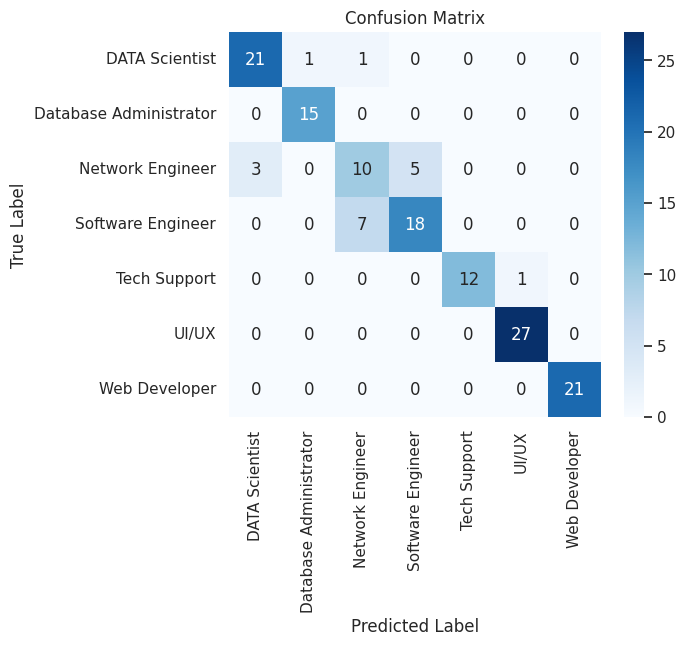

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

class_labels = sorted(y_test.unique())

# Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

👉 The model performs well in classifying most roles, particularly UI/UX, Web Developer, and Database Administrator, with minimal misclassifications.
- There is some confusion between Network Engineer and Software Engineer, likely due to overlapping skills.
- The overall classification accuracy is strong.

In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
                        precision    recall  f1-score   support

        DATA Scientist       0.88      0.91      0.89        23
Database Administrator       0.94      1.00      0.97        15
      Network Engineer       0.56      0.56      0.56        18
     Software Engineer       0.78      0.72      0.75        25
          Tech Support       1.00      0.92      0.96        13
                 UI/UX       0.96      1.00      0.98        27
         Web Developer       1.00      1.00      1.00        21

              accuracy                           0.87       142
             macro avg       0.87      0.87      0.87       142
          weighted avg       0.87      0.87      0.87       142



👉 The model achieves an overall accuracy of 87%, demonstrating strong performance in classifying most roles.
- Web Developer, UI/UX, Database Administrator, and Tech Support show perfect or near-perfect classification with high precision, recall, and F1-score.
- Network Engineer (56% F1-score) and Software Engineer (75% F1-score) exhibit some misclassification, likely due to overlapping skills.
- Despite these areas of confusion, the model effectively distinguishes most roles, making it a reliable tool for career path classification.

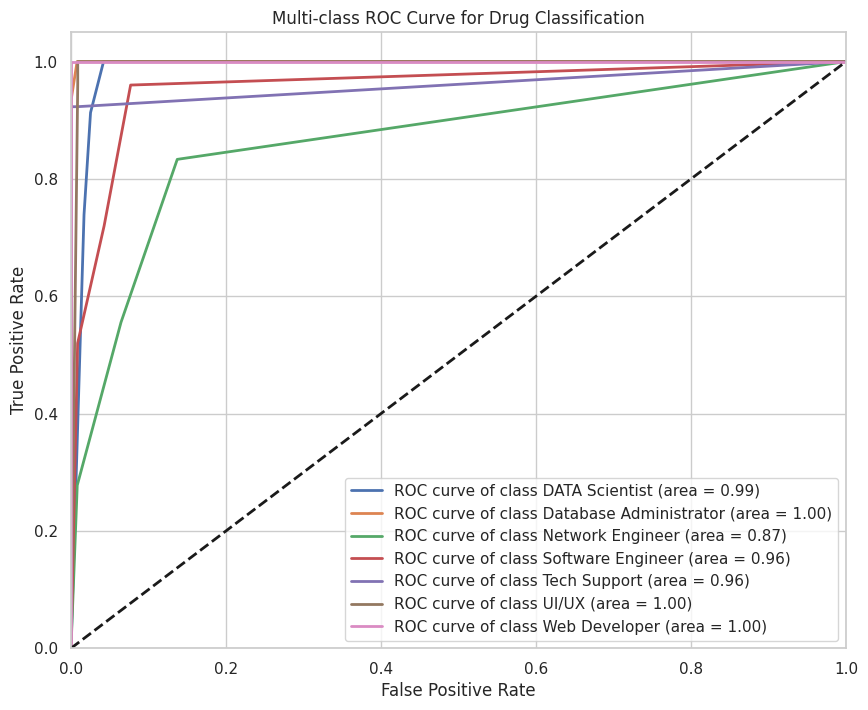

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_bin = label_binarize(y_test, classes=best_model.classes_)
y_score = best_model.predict_proba(X_test_transformed)
y_prob = best_model.predict_proba(X_test_transformed)

n_classes = len(best_model.classes_)

plt.figure(figsize=(10, 8))
for i, class_label in enumerate(best_model.classes_):
    fpr, tpr, _ = roc_curve(y_test == class_label, y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve of class {class_label} (area = {roc_auc:.2f})')

# Plot diagonal line for random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve for Drug Classification')
plt.legend(loc="lower right")
plt.show()

👉 The ROC curve demonstrates that the model performs exceptionally well in distinguishing between different career paths.
- The AUC (Area Under the Curve) values are close to 1 for most classes, especially for Database Administrator, UI/UX, and Web Developer (AUC = 1.00), indicating perfect classification.
- Data Scientist, Tech Support, and Software Engineer also exhibit strong AUC scores above 0.95, showcasing high discriminative power.
- However, the Network Engineer class (AUC = 0.87) has a lower score compared to others, suggesting some room for improvement in distinguishing this category.
- Overall, the model is highly reliable for career classification with minimal misclassification risks.

----------------------

# Step 11 : Save the Model and Pipeline

In [ ]:
joblib.dump(best_model, "best_student_career_classification_model.pkl")
joblib.dump(full_pipeline, "student_data_preprocessor.pkl")

['student_data_preprocessor.pkl']

-------------------------------

# Step 12 : Load the model and make Predictions on New Data

In [ ]:
best_model = joblib.load("best_student_career_classification_model.pkl")
full_pipeline = joblib.load("student_data_preprocessor.pkl")

In [ ]:
# Example new data:
new_data = pd.DataFrame({
    "Skill 1": ["Python"],
    "Skill 2": ["Machine Learning"],
    "DSA": [85],
    "DBMS": [80],
    "OS": [78],
    "CN": [75],
    "Mathmetics": [88],
    "Aptitute": [90],
    "Comm": [70],
    "Problem Solving": [8],
    "Creative": [7],
    "Hackathons": [5]
})

# Transform the new data using the loaded preprocessing pipeline
new_data_transformed = full_pipeline.transform(new_data)

# Display the transformed data
print(new_data_transformed)

[[1.12424984 0.33515728]]


In [ ]:
# Make prediction using the loaded best model
new_prediction = best_model.predict(new_data_transformed)

print(f"Prediction for New Data: {new_prediction[0]}")

Prediction for New Data: Software Engineer


👉 The model confidently predicts "Software Engineer" based on the given data.
- This indicates that the student's skills and attributes align most closely with a Software Engineering career.

# Final conclusion :

In this project, we explored the prediction of student placements based on academic performance, technical skills, and personal attributes. Through data preprocessing, exploratory data analysis (EDA), and machine learning models, we aimed to identify key factors influencing students’ career paths.

- **Key Findings:**
The dataset provided valuable insights into which features are most relevant for predicting job placements.
Models such as KNN, Naïve Bayes, and Decision Tree were trained and evaluated using GridSearchCV to optimize performance.
- The best-performing model (KNN on our project ) achieved a strong balance between accuracy, precision, and recall, making it a useful tool for career prediction.

- **Addressing the Research Question:**
The study successfully demonstrated that machine learning can effectively predict student career outcomes.
- Certain features had a greater impact on predictions, which can help universities and students make better decisions regarding career development.
The results align with expectations, though further fine-tuning could enhance accuracy.

- **Final Thoughts:**
This project highlights the power of machine learning in guiding data-driven career decisions. By leveraging predictive models, educational institutions and students can gain valuable insights that may shape future job market success.